# RNN - Model

In [1]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
# from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/Users/eduardomonteiro/code/mattwagon/oil_production_prediction/notebooks'

## Import the data

In [4]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = os.path.join('..', 'raw_data')
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

In [6]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


## Data cleaning

In [7]:
# Drop features with more than 30% NaN values
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)


# Drop features with std = 0
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)


# Drop corrected features
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)


# Drop choke features
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)


# Drop correlated features
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P', 'Qliq MPFM', 'Qwat MPFM']
df.drop(columns=features_corr_drop, inplace = True)


# Drop features in remove dictionary
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", 
          "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", 
          "Downhole Gauge T", "Downhole Gauge P"}

df.drop(columns=remove, inplace=True)

In [8]:
df.shape

(5813, 17)

## Impute features with <30% NaN values

In [9]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)
    
df.isnull().sum()

Date               0
WHT                0
WHP                0
Tubing Gradient    0
Service Line P     0
Sand Raw           0
Qoil MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold T         0
Manifold P         0
Jumper T           0
Choke Opening      0
Annulus P          0
dtype: int64

## LSTM model

### Select df_train and df_test

In [10]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [11]:
def plot_predictions(y_test, y_pred):
    plt.plot(y_test, c='red', label='Test')
    plt.plot(y_pred, c='blue', label='Pred')
    plt.legend()
    plt.show()

In [12]:
train_start_date = pd.to_datetime('2007-02-01')
train_end_date = pd.to_datetime('2019-12-31')
test_start_date = pd.to_datetime('2020-01-01')
test_end_date = pd.to_datetime('2022-12-31')

#train_start_date = pd.to_datetime('2010-01-01')
#train_end_date = pd.to_datetime('2022-12-31')
#test_start_date = pd.to_datetime('2007-02-01')
#test_end_date = pd.to_datetime('2009-12-31')

df_train = df[(df['Date']>=train_start_date) & (df['Date']<=train_end_date)]
df_test = df[(df['Date']>=test_start_date) & (df['Date']<=test_end_date)]

### Scaling with MinMaxScaler:

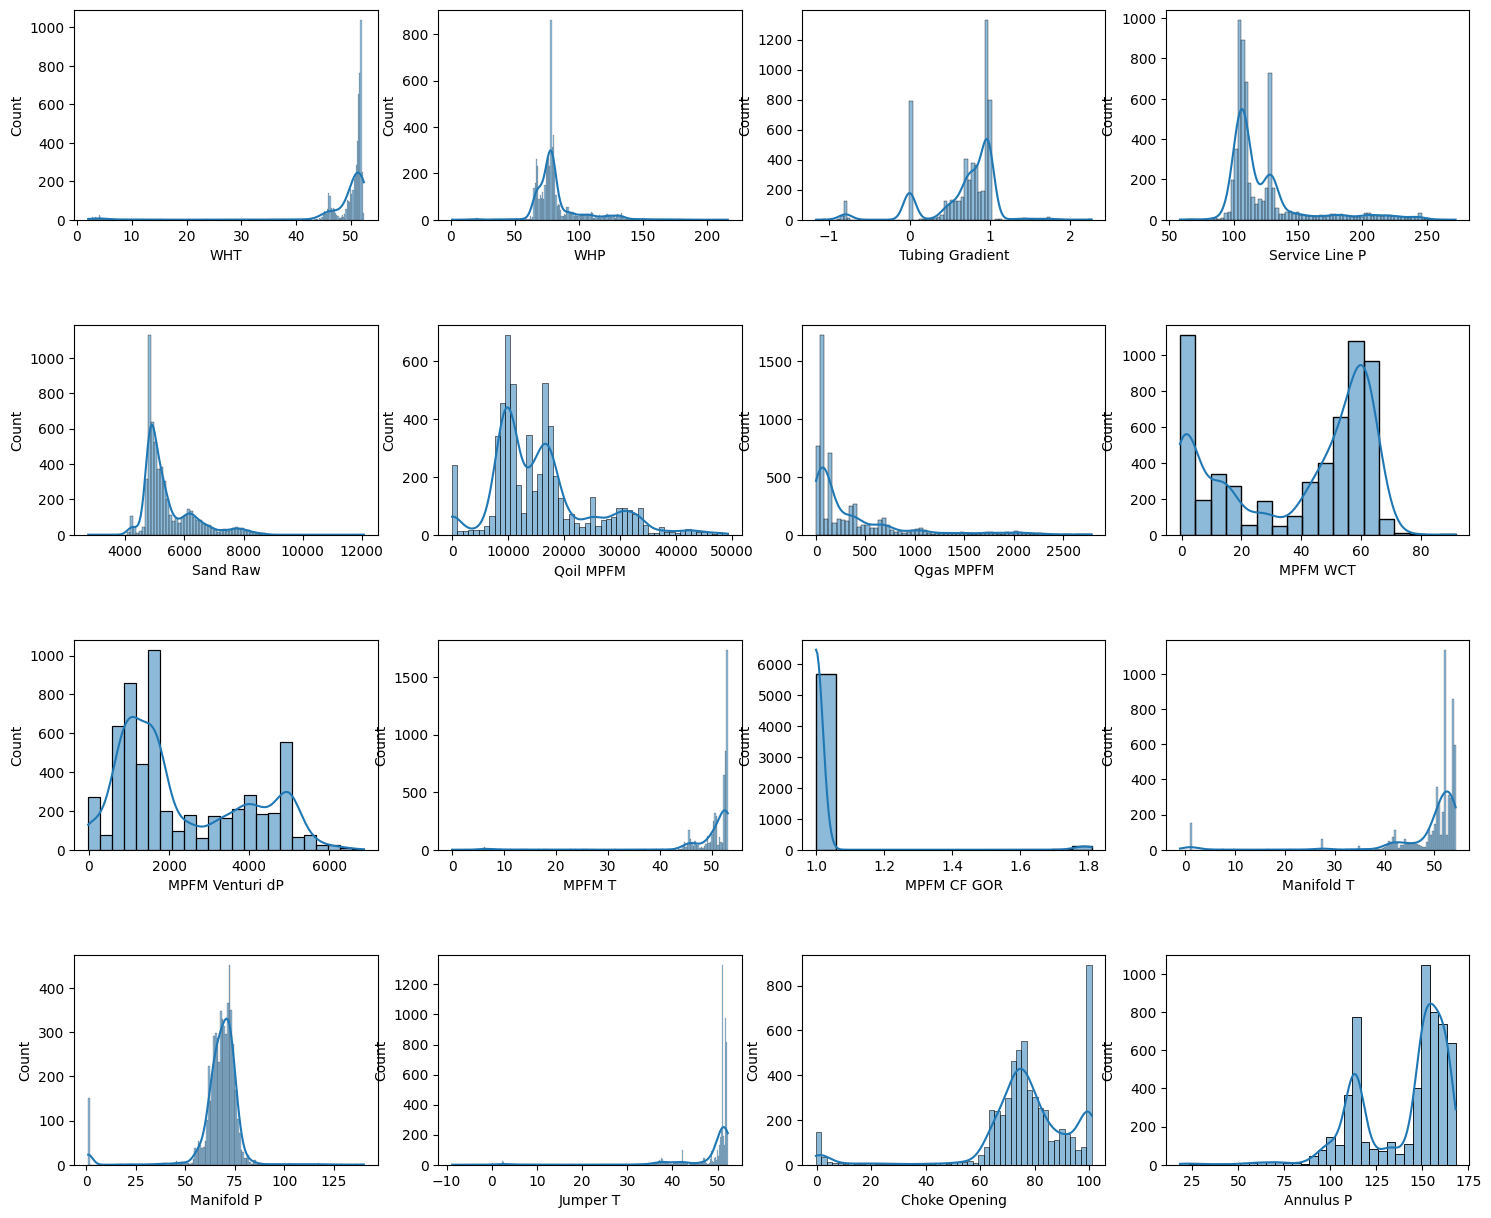

In [13]:
# Create a figure and axis for each histogram
fig, axs = plt.subplots(4, 4, figsize=(18, 15))

axs = axs.ravel()

for i, col in enumerate(df.drop(columns=['Date']).columns):
    sns.histplot(df.drop(columns=['Date'])[col], kde=True, ax=axs[i])

for j in range(len(df.drop(columns=['Date']).columns), len(axs)):
    axs[j].axis('off')

plt.subplots_adjust(hspace=0.5)

plt.show()

Use the cell below to scale the data before getting the sequences

In [14]:
#scaler_X = MinMaxScaler(feature_range=(0,1))
#X_train_scaled = pd.DataFrame(scaler_X.fit_transform(df_train.drop(columns='Date')), columns=df_train.drop(columns='Date').columns)
#X_test_scaled = pd.DataFrame(scaler_X.transform(df_test.drop(columns='Date')), columns=df_test.drop(columns='Date').columns)

#scaler_y = MinMaxScaler(feature_range=(0,1))
#y_train_scaled = pd.DataFrame(scaler_y.fit_transform(df_test['Qoil MPFM'].values.reshape(-1,1)), columns=['Qoil MPFM'])
#y_test_scaled = pd.DataFrame(scaler_y.transform(df_test['Qoil MPFM'].values.reshape(-1,1)), columns=['Qoil MPFM'])

In [15]:
def subsample_sequence(sequence, length, horizon):

    # Bounds of sampling
    last_possible = len(sequence) - length - horizon
    random_start = np.random.randint(0, last_possible)

    # Sample
    X = sequence.iloc[random_start:random_start + length, :].drop(columns=['Date'])
    #iloc[random_start:random_start + length, :] 
    #[random_start:random_start +length].drop(columns=['Date','Qoil MPFM']) 
    y = sequence.iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #loc[random_start+length+horizon-1]['Qoil MPFM']

    return X, y


subsample_sequence(df_train, 3, 1)

(            WHT        WHP  Tubing Gradient  Service Line P     Sand Raw  \
 2863  51.028679  73.797112         0.807311      122.390320  5124.187500   
 2864  51.025307  73.722336         0.807003      122.884178  5097.014160   
 2865  51.029205  73.801643         0.806013      123.099617  5138.928223   
 
          Qoil MPFM   Qgas MPFM   MPFM WCT  MPFM Venturi dP     MPFM T  \
 2863  16629.036189  339.869039  49.647053      3205.829346  51.883743   
 2864  16534.047531  359.488875  49.333500      3020.030518  51.865337   
 2865  16830.508610  354.356578  48.811920      3041.770752  51.876637   
 
       MPFM CF GOR  Manifold T  Manifold P   Jumper T  Choke Opening  \
 2863          1.0   51.940947   69.975616  51.085567     100.230400   
 2864          1.0   51.940947   69.988876  51.085567     100.129456   
 2865          1.0   51.940947   69.904068  51.085567     100.318176   
 
        Annulus P  
 2863  161.592636  
 2864  161.566269  
 2865  161.565353  ,
 2866    16852.423134

In [16]:
def get_X_y(sequence, length, horizon, number_of_samples):
    
    X, y = [], []
    
    # Do as many samples as specified
    for sample in range(1,number_of_samples + 1):
    
        # Record sample X & y
        xi, yi = subsample_sequence(sequence, length, horizon)
        X.append(np.array(xi.values.T.tolist()).T) # Getting the right shape (sequences, observations,features)
        y.append(yi)

    return np.array(X), np.array(y)

In [17]:
X_train, y_train = get_X_y(sequence=df_train,
               length=500,
               horizon=1,
               number_of_samples=5000)

In [18]:
X_test, y_test = get_X_y(sequence=df_test,
               length=500,
               horizon=1,
               number_of_samples=1000)

In [19]:
y_train.shape

(5000, 1)

In [20]:
X_test.shape

(1000, 500, 16)

In [21]:
# check shape after reshaping
X_train_reshape = X_train.reshape(X_train.shape[0], -1)
X_train_reshape.shape

(5000, 8000)

Scaling the data after getting the sequences

In [22]:
from sklearn.preprocessing import RobustScaler, StandardScaler

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
#scaler_X = RobustScaler()
#scaler_y = RobustScaler()
#scaler_X = StandardScaler()
#scaler_y = StandardScaler()


X_train = scaler_X.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler_X.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1,y_train.shape[-1])).reshape(y_train.shape)
y_test = scaler_y.transform(y_test.reshape(-1,y_test.shape[1])).reshape(y_test.shape)

In [23]:
X_train.shape

(5000, 500, 16)

In [24]:
df_test.shape

(1096, 17)

### Baseline model

In [23]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    model = models.Sequential()
    model.add(Lambda(lambda x: x[:, -1, 1, None]))
    
    adam = optimizers.Adam(learning_rate = 0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [24]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)}")

32/32 [==============================] - 0s 317us/step - loss: 0.0033 - mae: 0.0370
- The Baseline MAE on the test set is equal to 0.04


2023-03-27 22:59:17.834605: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [25]:
res = {}

res['baseline_score'] = baseline_score[1]

### Model 1 - First LSTM model

In [26]:
def init_model_1(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    #model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(16, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.2))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [27]:
model_1 = init_model_1(X_train, y_train)
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 2,129
Trainable params: 2,129
Non-trainable params: 0
_________________________________________________________________


In [28]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [29]:
model_1, history_1 = fit_model(model_1)

Epoch 1/50
110/110 [==============================] - 6s 51ms/step - loss: 0.0517 - mae: 0.1553 - val_loss: 0.0208 - val_mae: 0.1065
Epoch 2/50
110/110 [==============================] - 5s 49ms/step - loss: 0.0153 - mae: 0.0805 - val_loss: 0.0153 - val_mae: 0.0827
Epoch 3/50
110/110 [==============================] - 5s 49ms/step - loss: 0.0137 - mae: 0.0722 - val_loss: 0.0103 - val_mae: 0.0584
Epoch 4/50
110/110 [==============================] - 6s 54ms/step - loss: 0.0131 - mae: 0.0727 - val_loss: 0.0122 - val_mae: 0.0793
Epoch 5/50
110/110 [==============================] - 5s 49ms/step - loss: 0.0119 - mae: 0.0655 - val_loss: 0.0108 - val_mae: 0.0544
Epoch 6/50
110/110 [==============================] - 5s 48ms/step - loss: 0.0116 - mae: 0.0655 - val_loss: 0.0107 - val_mae: 0.0478
Epoch 7/50
110/110 [==============================] - 5s 48ms/step - loss: 0.0113 - mae: 0.0639 - val_loss: 0.0103 - val_mae: 0.0478
Epoch 8/50
110/110 [==============================] - 5s 48ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

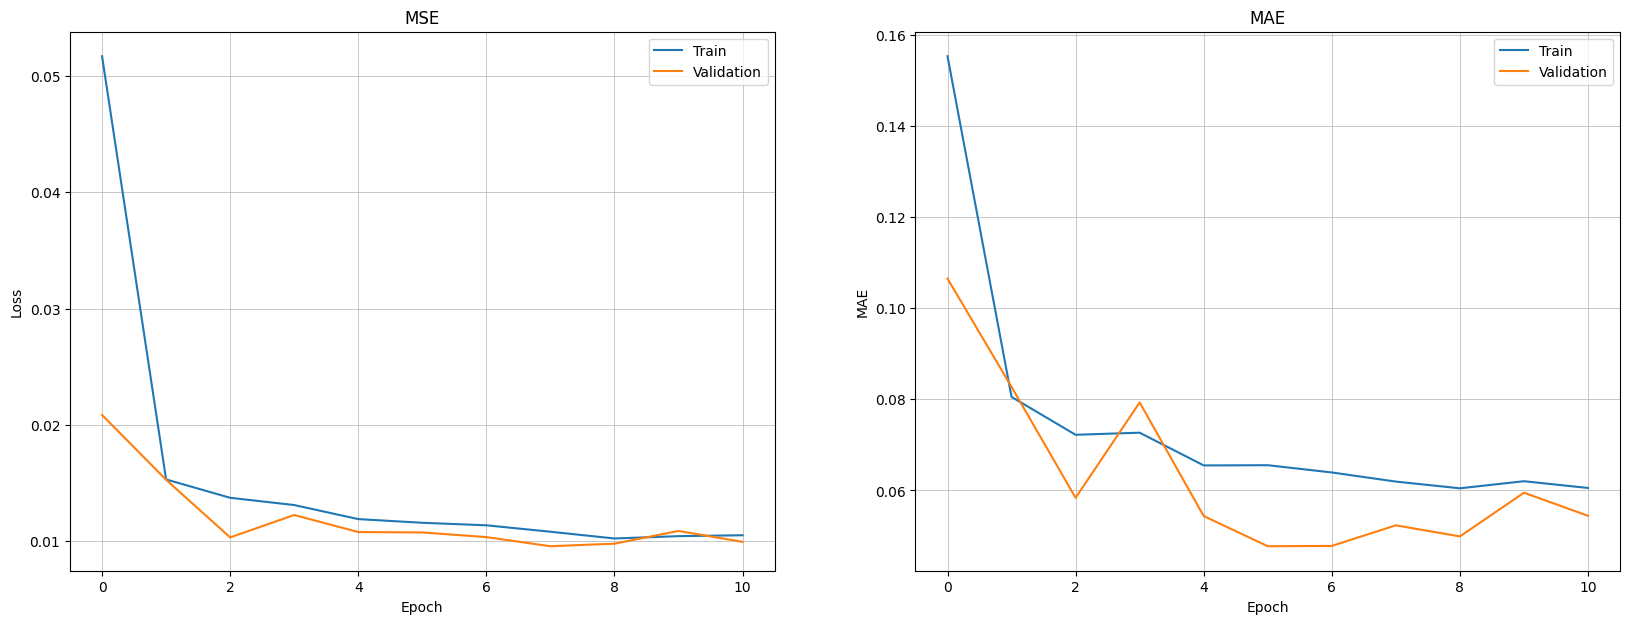

In [30]:
plot_history(history_1)

In [31]:
res1 = model_1.evaluate(X_test, y_test, verbose=0)
res1

[0.0013924394734203815, 0.021047960966825485]

In [32]:
res['model_1_score'] = res1[1]

In [33]:
y_pred_1 = model_1.predict(X_test)
y_pred_1

32/32 [==============================] - 1s 9ms/step


array([[0.29016238],
       [0.30755618],
       [0.29416454],
       [0.2874024 ],
       [0.28640985],
       [0.2927891 ],
       [0.2989873 ],
       [0.2881391 ],
       [0.29626364],
       [0.29800323],
       [0.28410006],
       [0.2968256 ],
       [0.28212103],
       [0.29369563],
       [0.24985713],
       [0.2887383 ],
       [0.21276608],
       [0.2942982 ],
       [0.28716245],
       [0.29498902],
       [0.21276608],
       [0.28340513],
       [0.16690227],
       [0.2863822 ],
       [0.28909373],
       [0.29105732],
       [0.29744756],
       [0.2603826 ],
       [0.29624158],
       [0.2960648 ],
       [0.28531656],
       [0.2854337 ],
       [0.29646727],
       [0.26467156],
       [0.28719026],
       [0.28324115],
       [0.2923056 ],
       [0.29493594],
       [0.28596658],
       [0.29179946],
       [0.29560024],
       [0.29586008],
       [0.29730573],
       [0.29493594],
       [0.29940957],
       [0.29435882],
       [0.2824807 ],
       [0.299

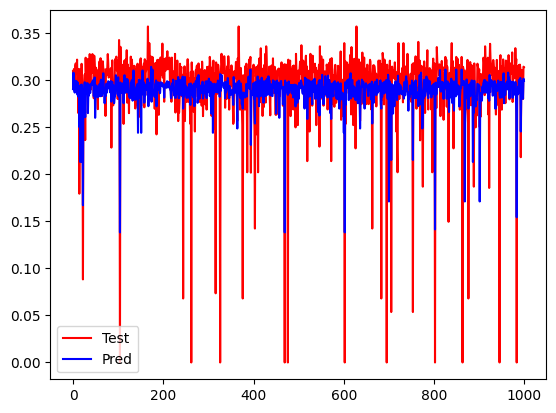

In [34]:
plot_predictions(y_test,y_pred_1)

In [35]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_1_unscaled = scaler_y.inverse_transform(y_pred_1)

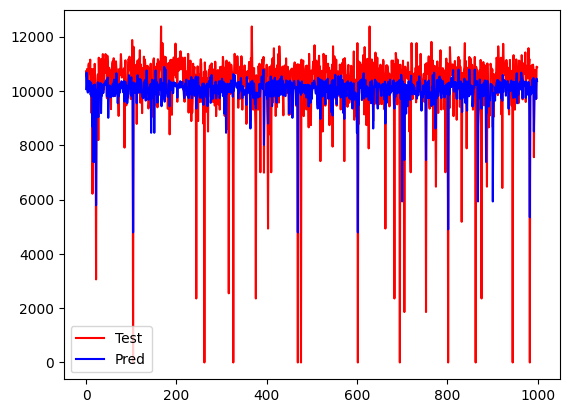

In [36]:
plot_predictions(y_test_unscaled, y_pred_1_unscaled)

### Model 2 - Changing number of neurons

In [37]:
def init_model_2(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    #model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(normalizer)
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.2))
    #model.add(layers.LSTM(8, activation='tanh'))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [38]:
model_2 = init_model_2(X_train, y_train)
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [39]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [40]:
model_2, history_2 = fit_model(model_2)

Epoch 1/50
110/110 [==============================] - 6s 46ms/step - loss: 0.0737 - mae: 0.1742 - val_loss: 0.0153 - val_mae: 0.0835
Epoch 2/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0173 - mae: 0.0818 - val_loss: 0.0104 - val_mae: 0.0564
Epoch 3/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0153 - mae: 0.0752 - val_loss: 0.0110 - val_mae: 0.0666
Epoch 4/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0149 - mae: 0.0727 - val_loss: 0.0097 - val_mae: 0.0487
Epoch 5/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0133 - mae: 0.0704 - val_loss: 0.0099 - val_mae: 0.0532
Epoch 6/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0122 - mae: 0.0665 - val_loss: 0.0098 - val_mae: 0.0585
Epoch 7/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0123 - mae: 0.0657 - val_loss: 0.0105 - val_mae: 0.0699
Epoch 8/50
110/110 [==============================] - 5s 44ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

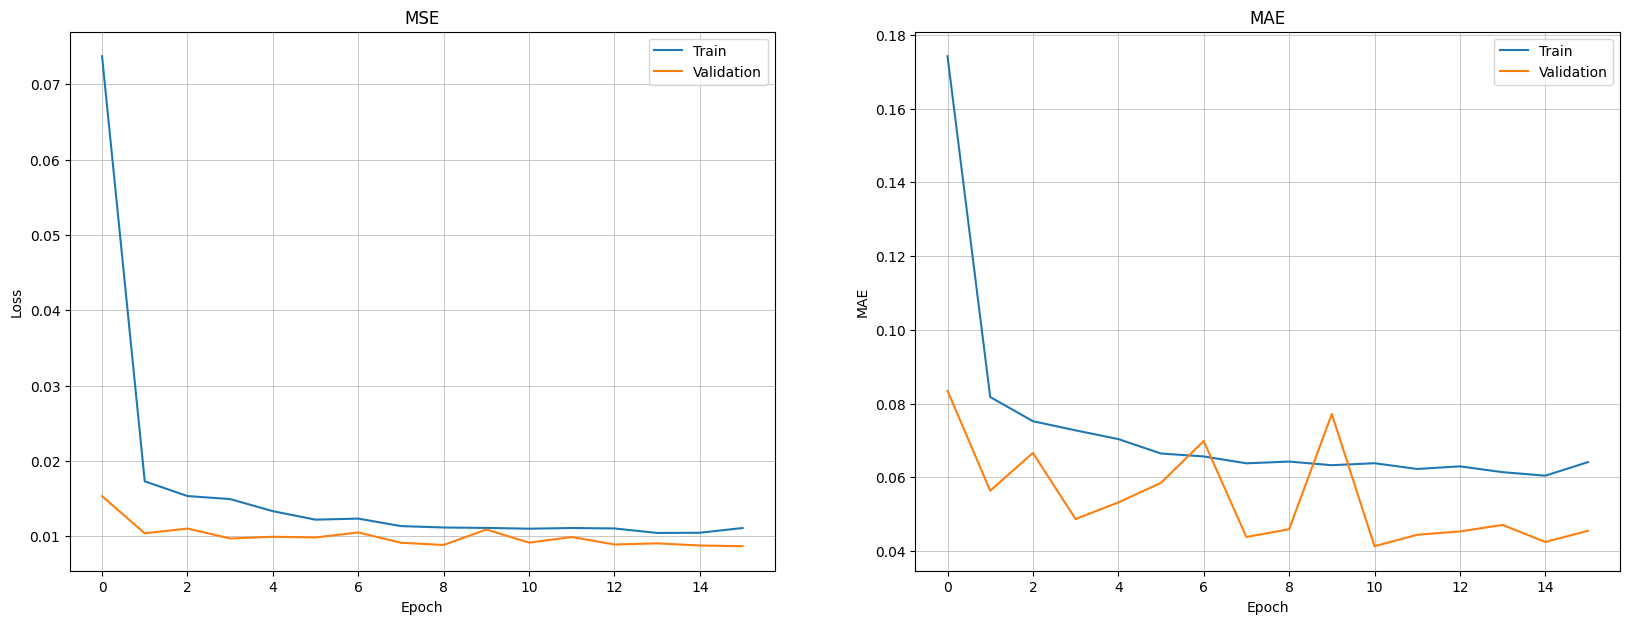

In [41]:
plot_history(history_2)

In [42]:
res2 = model_2.evaluate(X_test, y_test, verbose=0)
res2

[0.0016100637149065733, 0.025921424850821495]

In [43]:
res['model_2_score'] = res2[1]

In [44]:
y_pred_2 = model_2.predict(X_test)
y_pred_2

32/32 [==============================] - 0s 8ms/step


array([[0.3071146 ],
       [0.300559  ],
       [0.27840048],
       [0.28136078],
       [0.27628073],
       [0.27510875],
       [0.28276178],
       [0.27364975],
       [0.3181299 ],
       [0.3127824 ],
       [0.27604103],
       [0.3181764 ],
       [0.2717911 ],
       [0.28037488],
       [0.23571858],
       [0.27131814],
       [0.14907873],
       [0.2814172 ],
       [0.27819577],
       [0.3106962 ],
       [0.14907873],
       [0.27339792],
       [0.16785452],
       [0.27584833],
       [0.27960372],
       [0.27990937],
       [0.316943  ],
       [0.23910302],
       [0.27134705],
       [0.31401545],
       [0.26940453],
       [0.27485234],
       [0.31637463],
       [0.24978808],
       [0.2704132 ],
       [0.2804361 ],
       [0.27007154],
       [0.28236565],
       [0.27857268],
       [0.31894073],
       [0.28379652],
       [0.31799668],
       [0.28700233],
       [0.28236565],
       [0.3194473 ],
       [0.2773412 ],
       [0.26605913],
       [0.322

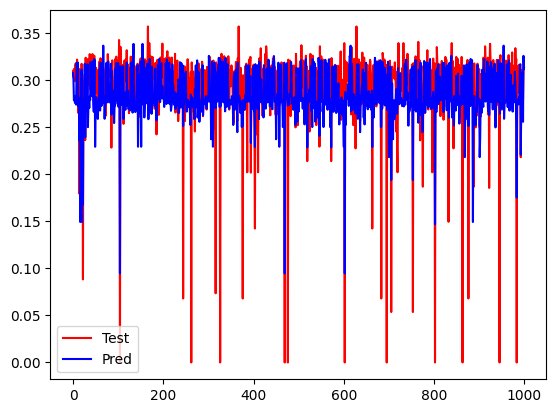

In [45]:
plot_predictions(y_test, y_pred_2)

In [46]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_2_unscaled = scaler_y.inverse_transform(y_pred_2)

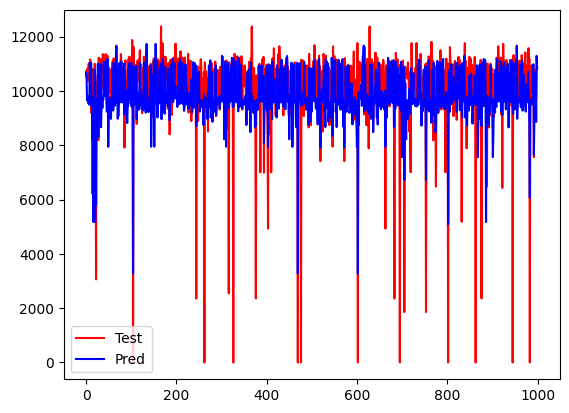

In [47]:
plot_predictions(y_test_unscaled, y_pred_2_unscaled)

### Model 3 - Changing dropout rate

In [48]:
def init_model_3(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.4))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [49]:
model_3 = init_model_3(X_train, y_train)
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [50]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [51]:
model_3, history_3 = fit_model(model_3)

Epoch 1/50
110/110 [==============================] - 6s 46ms/step - loss: 0.0433 - mae: 0.1462 - val_loss: 0.0132 - val_mae: 0.0759
Epoch 2/50
110/110 [==============================] - 5s 45ms/step - loss: 0.0165 - mae: 0.0880 - val_loss: 0.0152 - val_mae: 0.0954
Epoch 3/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0148 - mae: 0.0803 - val_loss: 0.0116 - val_mae: 0.0563
Epoch 4/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0154 - mae: 0.0822 - val_loss: 0.0100 - val_mae: 0.0546
Epoch 5/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0142 - mae: 0.0774 - val_loss: 0.0098 - val_mae: 0.0515
Epoch 6/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0135 - mae: 0.0754 - val_loss: 0.0117 - val_mae: 0.0683
Epoch 7/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0140 - mae: 0.0753 - val_loss: 0.0116 - val_mae: 0.0686
Epoch 8/50
110/110 [==============================] - 5s 44ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

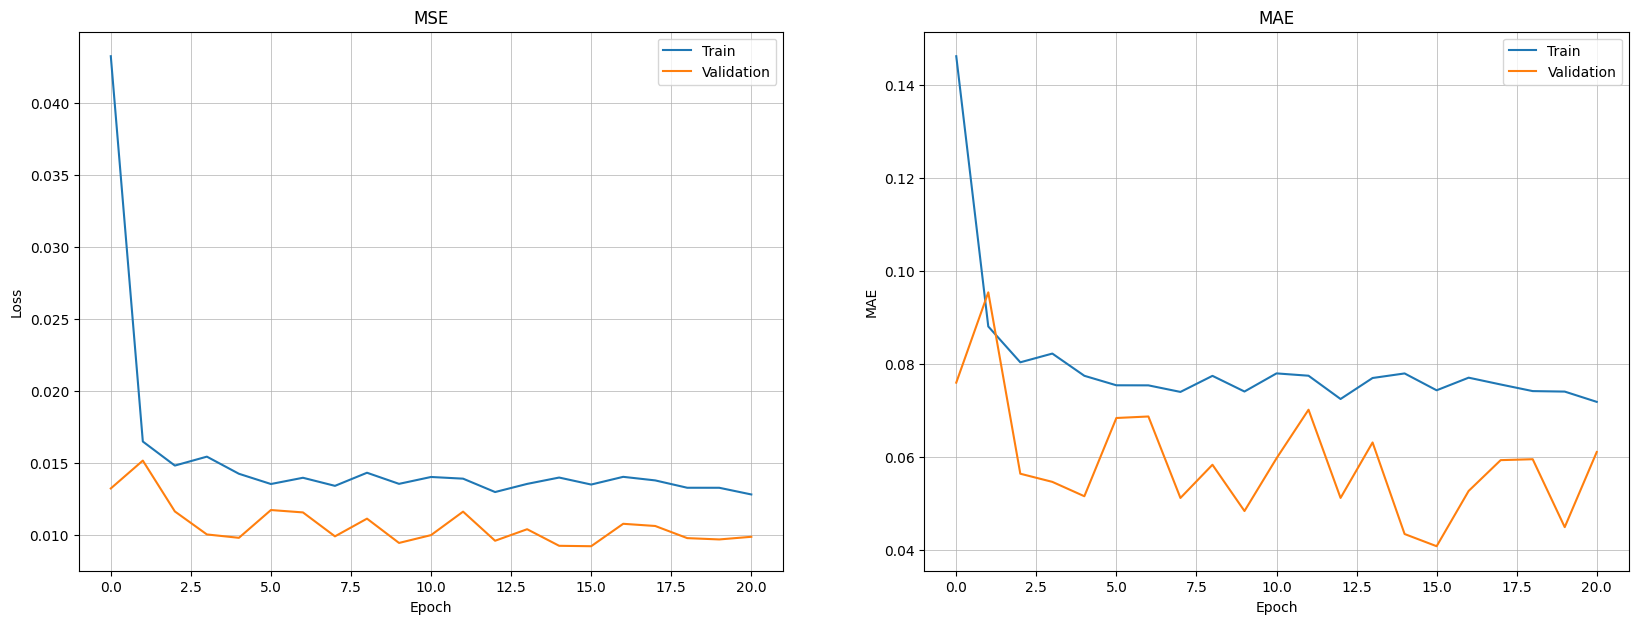

In [54]:
plot_history(history_3)

In [55]:
res3 = model_3.evaluate(X_test, y_test, verbose=0)
res3

[0.002269150922074914, 0.03747788816690445]

In [56]:
res['model_3_score'] = res3[1]

In [57]:
y_pred_3 = model_3.predict(X_test)
y_pred_3

32/32 [==============================] - 0s 8ms/step


array([[0.2632787 ],
       [0.27778363],
       [0.27108908],
       [0.26885003],
       [0.26957715],
       [0.2711276 ],
       [0.2751126 ],
       [0.27271444],
       [0.26572508],
       [0.26429355],
       [0.26651442],
       [0.26364082],
       [0.2664498 ],
       [0.27202317],
       [0.28775597],
       [0.2687445 ],
       [0.08812687],
       [0.2713012 ],
       [0.27029976],
       [0.26632297],
       [0.08812687],
       [0.26211432],
       [0.14084429],
       [0.2643147 ],
       [0.27015495],
       [0.2714333 ],
       [0.26407066],
       [0.24114189],
       [0.27399915],
       [0.26478398],
       [0.26476184],
       [0.2681452 ],
       [0.26579812],
       [0.2531065 ],
       [0.26420984],
       [0.26925188],
       [0.26985657],
       [0.27534395],
       [0.2676829 ],
       [0.26166308],
       [0.27304804],
       [0.2653063 ],
       [0.27604288],
       [0.27534395],
       [0.26652282],
       [0.27261674],
       [0.26550198],
       [0.268

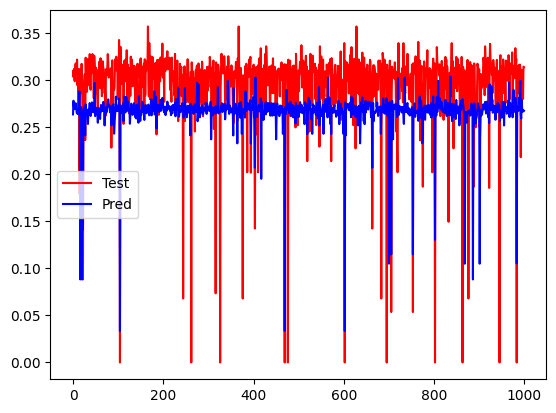

In [58]:
plot_predictions(y_test, y_pred_3)

In [59]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_3_unscaled = scaler_y.inverse_transform(y_pred_3)

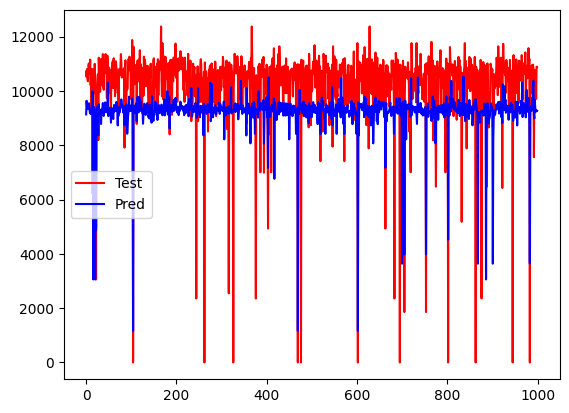

In [60]:
plot_predictions(y_test_unscaled, y_pred_3_unscaled)

### Model 4 - Changing learning rate

In [61]:
def init_model_4(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.4))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.01)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [62]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [63]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [64]:
model_4, history_4 = fit_model(model_4)

Epoch 1/50
110/110 [==============================] - 6s 46ms/step - loss: 0.0857 - mae: 0.2047 - val_loss: 0.0219 - val_mae: 0.0960
Epoch 2/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0262 - mae: 0.1108 - val_loss: 0.0127 - val_mae: 0.0628
Epoch 3/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0182 - mae: 0.0891 - val_loss: 0.0123 - val_mae: 0.0712
Epoch 4/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0148 - mae: 0.0785 - val_loss: 0.0107 - val_mae: 0.0587
Epoch 5/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0142 - mae: 0.0757 - val_loss: 0.0104 - val_mae: 0.0539
Epoch 6/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0132 - mae: 0.0727 - val_loss: 0.0108 - val_mae: 0.0607
Epoch 7/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0132 - mae: 0.0717 - val_loss: 0.0103 - val_mae: 0.0585
Epoch 8/50
110/110 [==============================] - 5s 44ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

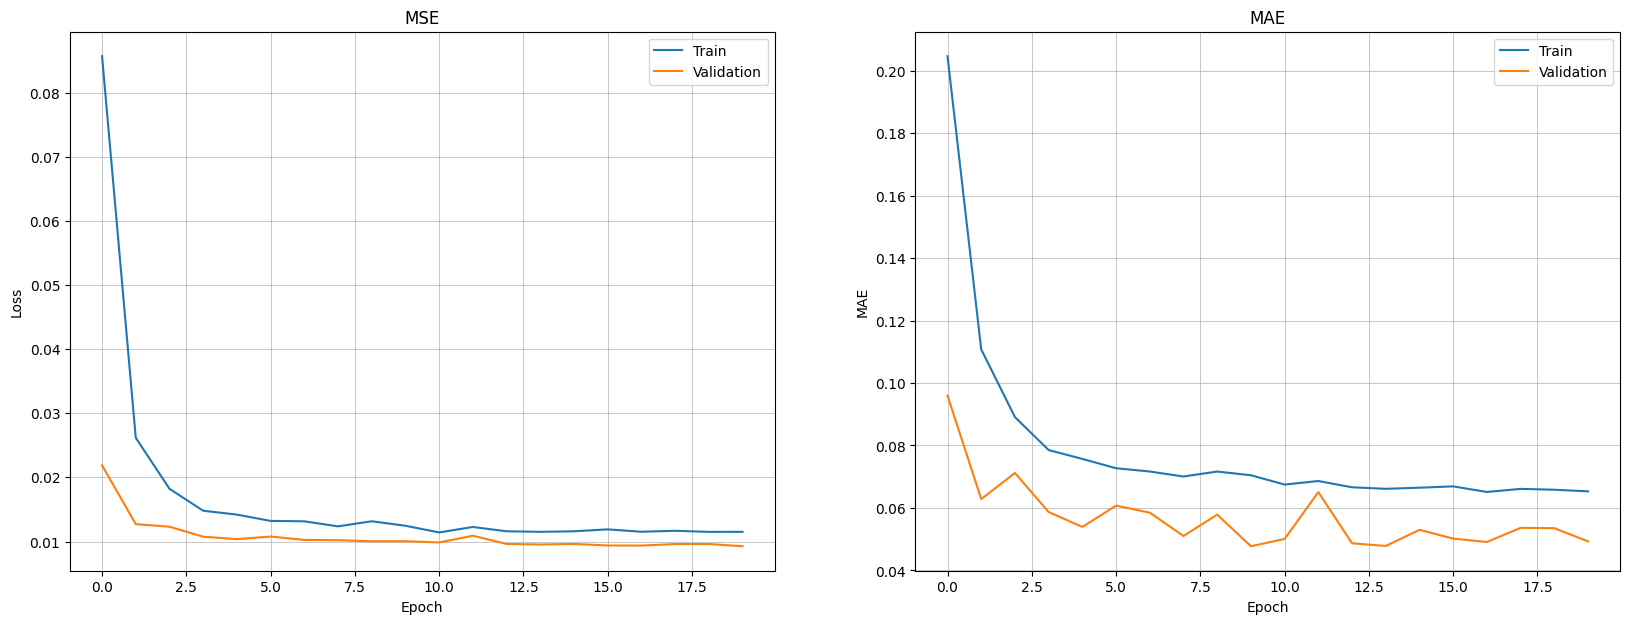

In [65]:
plot_history(history_4)

In [66]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[0.002037168014794588, 0.031945157796144485]

In [67]:
res['model_4_score'] = res4[1]

In [68]:
y_pred_4 = model_4.predict(X_test)
y_pred_4

32/32 [==============================] - 0s 8ms/step


array([[0.25393838],
       [0.29675058],
       [0.2860717 ],
       [0.2855403 ],
       [0.28793827],
       [0.284658  ],
       [0.28942037],
       [0.2867915 ],
       [0.25551546],
       [0.256133  ],
       [0.28180298],
       [0.2550153 ],
       [0.2822248 ],
       [0.28639355],
       [0.27456838],
       [0.29226187],
       [0.19802348],
       [0.28504106],
       [0.28804865],
       [0.25469792],
       [0.19802348],
       [0.28623357],
       [0.2160042 ],
       [0.28249165],
       [0.2828254 ],
       [0.29170662],
       [0.25734115],
       [0.26703387],
       [0.28776538],
       [0.256656  ],
       [0.28019285],
       [0.2877828 ],
       [0.2551012 ],
       [0.2575325 ],
       [0.2796931 ],
       [0.2819879 ],
       [0.28486487],
       [0.28933293],
       [0.2852511 ],
       [0.2533621 ],
       [0.2860736 ],
       [0.25589085],
       [0.28808945],
       [0.28933293],
       [0.2576825 ],
       [0.28602034],
       [0.2849944 ],
       [0.257

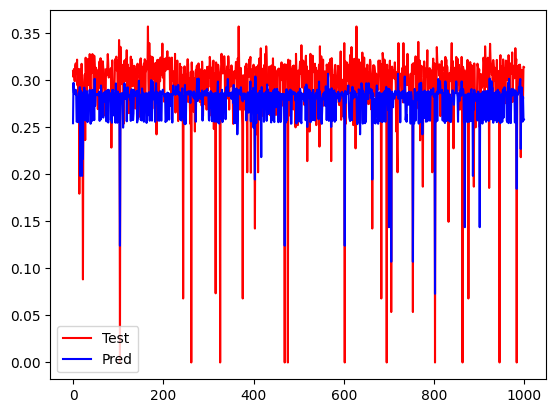

In [69]:
plot_predictions(y_test, y_pred_4)

In [70]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_4_unscaled = scaler_y.inverse_transform(y_pred_4)

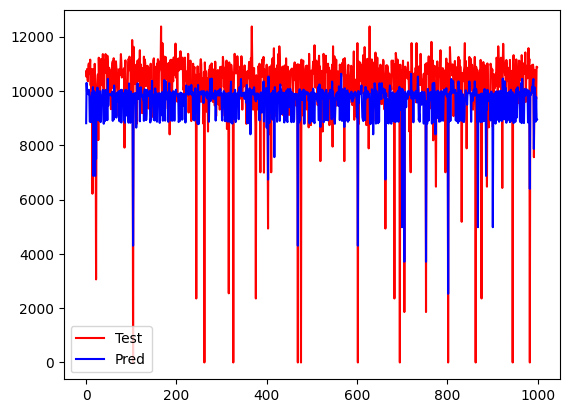

In [71]:
plot_predictions(y_test_unscaled, y_pred_4_unscaled)

### Model 5 - Trying to find the best model

In [72]:
def init_model_5(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [73]:
model_5 = init_model_5(X_train, y_train)
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [74]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [75]:
model_5, history_5 = fit_model(model_5)

Epoch 1/50
110/110 [==============================] - 6s 46ms/step - loss: 0.0435 - mae: 0.1451 - val_loss: 0.0156 - val_mae: 0.0823
Epoch 2/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0164 - mae: 0.0844 - val_loss: 0.0120 - val_mae: 0.0739
Epoch 3/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0132 - mae: 0.0709 - val_loss: 0.0109 - val_mae: 0.0656
Epoch 4/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0115 - mae: 0.0630 - val_loss: 0.0106 - val_mae: 0.0641
Epoch 5/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0112 - mae: 0.0625 - val_loss: 0.0100 - val_mae: 0.0507
Epoch 6/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0107 - mae: 0.0605 - val_loss: 0.0101 - val_mae: 0.0467
Epoch 7/50
110/110 [==============================] - 5s 44ms/step - loss: 0.0114 - mae: 0.0622 - val_loss: 0.0097 - val_mae: 0.0496
Epoch 8/50
110/110 [==============================] - 5s 45ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

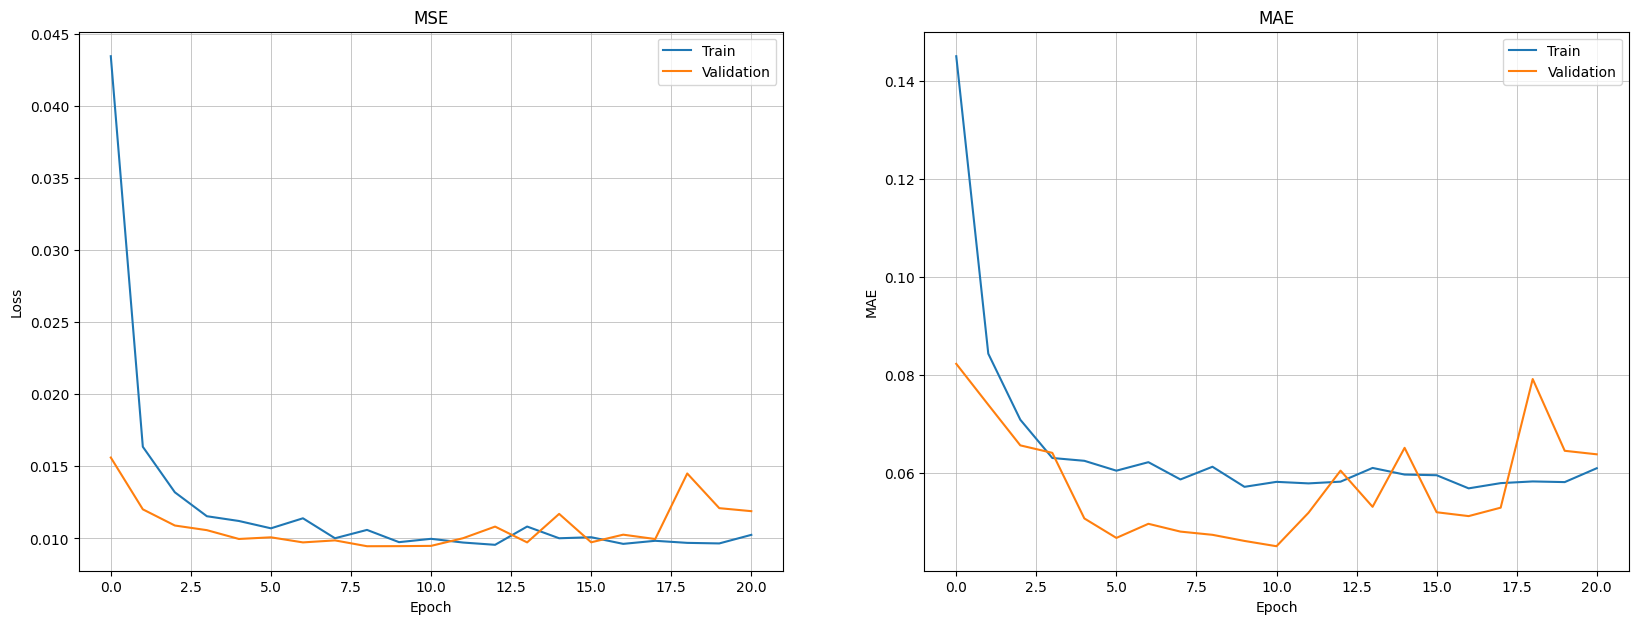

In [76]:
plot_history(history_5)

In [77]:
res5 = model_5.evaluate(X_test, y_test, verbose=0)
res5

[0.0016369071090593934, 0.029720492660999298]

In [78]:
res['model_5_score'] = res5[1]

In [79]:
y_pred_5 = model_5.predict(X_test)
y_pred_5

32/32 [==============================] - 0s 8ms/step


array([[0.28061137],
       [0.2896423 ],
       [0.27761644],
       [0.27614996],
       [0.27512383],
       [0.2760927 ],
       [0.28033072],
       [0.27545568],
       [0.28700113],
       [0.28559223],
       [0.27252936],
       [0.28676063],
       [0.27227953],
       [0.27837017],
       [0.22503403],
       [0.27441943],
       [0.19029197],
       [0.2787005 ],
       [0.27637595],
       [0.2841009 ],
       [0.19029197],
       [0.27155495],
       [0.17377964],
       [0.27175516],
       [0.27674752],
       [0.27740222],
       [0.28719145],
       [0.2503956 ],
       [0.27594882],
       [0.28568342],
       [0.27167755],
       [0.27415442],
       [0.28649104],
       [0.25204203],
       [0.27179298],
       [0.27209753],
       [0.2732612 ],
       [0.2804868 ],
       [0.27396107],
       [0.28500864],
       [0.27877575],
       [0.2870466 ],
       [0.28148544],
       [0.2804868 ],
       [0.28862995],
       [0.27752423],
       [0.26994807],
       [0.289

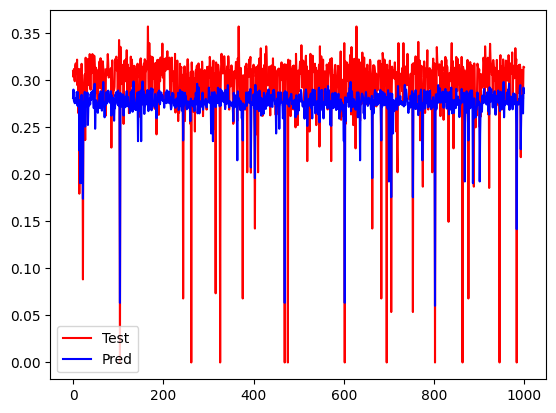

In [80]:
plot_predictions(y_test, y_pred_5)

In [81]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_5_unscaled = scaler_y.inverse_transform(y_pred_5)

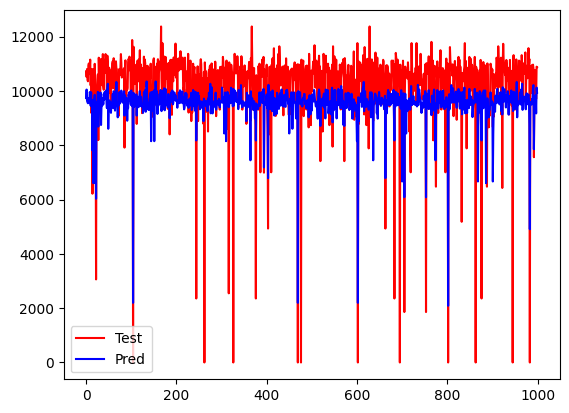

In [82]:
plot_predictions(y_test_unscaled, y_pred_5_unscaled)

### Model 6 - Changing optimizer

In [83]:
def init_model_6(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    nadam = optimizers.Nadam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=nadam,
                 metrics=['mae'])
    
    return model

In [84]:
model_6 = init_model_6(X_train, y_train)
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [85]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=32,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [86]:
model_6, history_6 = fit_model(model_6)

Epoch 1/50
110/110 [==============================] - 6s 46ms/step - loss: 0.0346 - mae: 0.1218 - val_loss: 0.0113 - val_mae: 0.0635
Epoch 2/50
110/110 [==============================] - 5s 45ms/step - loss: 0.0146 - mae: 0.0792 - val_loss: 0.0146 - val_mae: 0.0748
Epoch 3/50
110/110 [==============================] - 5s 45ms/step - loss: 0.0119 - mae: 0.0685 - val_loss: 0.0105 - val_mae: 0.0491
Epoch 4/50
110/110 [==============================] - 5s 46ms/step - loss: 0.0118 - mae: 0.0666 - val_loss: 0.0122 - val_mae: 0.0611
Epoch 5/50
110/110 [==============================] - 5s 46ms/step - loss: 0.0112 - mae: 0.0640 - val_loss: 0.0168 - val_mae: 0.0895
Epoch 6/50
110/110 [==============================] - 5s 49ms/step - loss: 0.0109 - mae: 0.0625 - val_loss: 0.0124 - val_mae: 0.0631
Epoch 7/50
110/110 [==============================] - 5s 48ms/step - loss: 0.0105 - mae: 0.0621 - val_loss: 0.0136 - val_mae: 0.0714
Epoch 8/50
110/110 [==============================] - 5s 46ms/step - 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

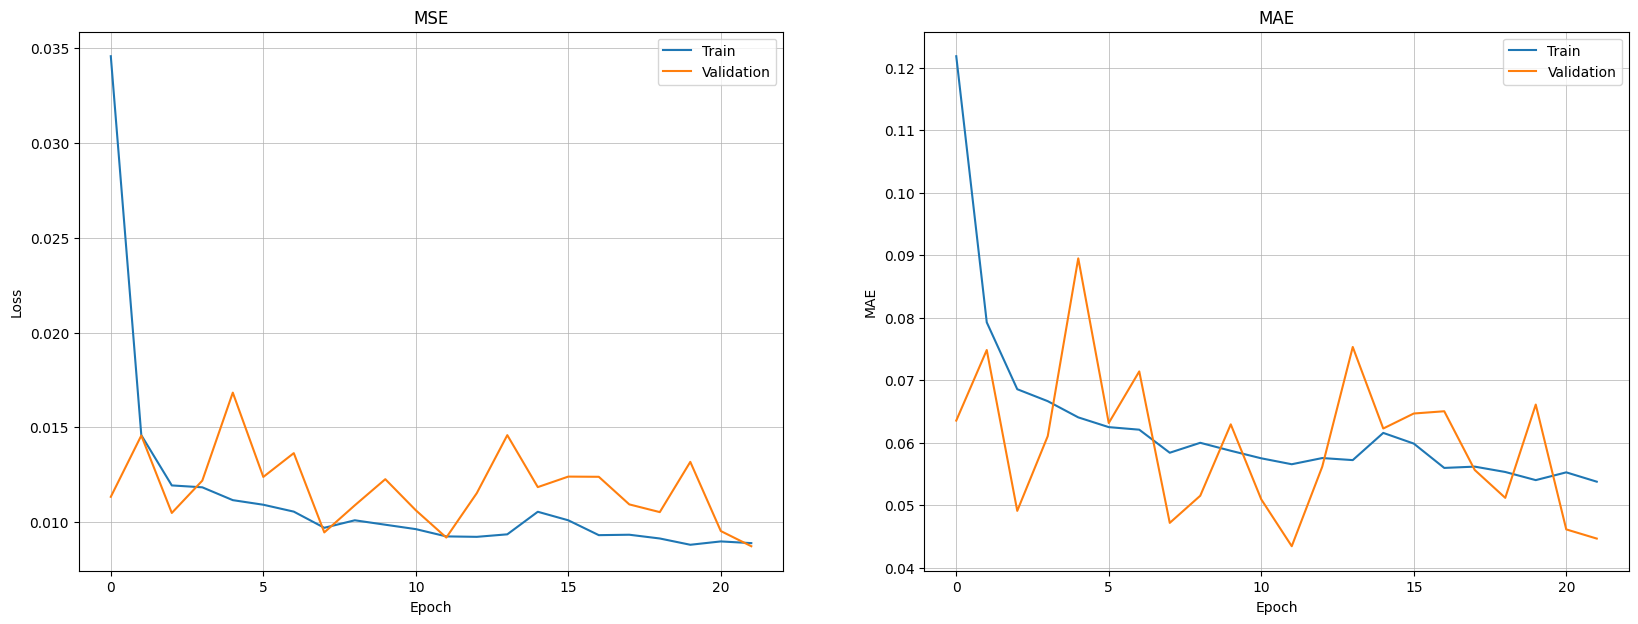

In [87]:
plot_history(history_6)

In [88]:
res6 = model_6.evaluate(X_test, y_test, verbose=0)
res6

[0.002672536065801978, 0.04398607090115547]

In [89]:
res['model_6_score'] = res6[1]

In [90]:
y_pred_6 = model_6.predict(X_test)
y_pred_6

32/32 [==============================] - 0s 8ms/step


array([[0.24598241],
       [0.27047354],
       [0.26749846],
       [0.2585715 ],
       [0.2611341 ],
       [0.2674613 ],
       [0.27219853],
       [0.265958  ],
       [0.25313103],
       [0.25446755],
       [0.2549103 ],
       [0.25476104],
       [0.25824824],
       [0.26767883],
       [0.23514071],
       [0.25700265],
       [0.14760467],
       [0.2706896 ],
       [0.26315367],
       [0.25430873],
       [0.14760467],
       [0.25089306],
       [0.08624282],
       [0.25660595],
       [0.26155117],
       [0.26652244],
       [0.2528298 ],
       [0.23006457],
       [0.26822865],
       [0.2523711 ],
       [0.26243067],
       [0.2584086 ],
       [0.25525087],
       [0.24027652],
       [0.26250553],
       [0.2553681 ],
       [0.26561943],
       [0.26312563],
       [0.25641853],
       [0.2519858 ],
       [0.27041638],
       [0.2544366 ],
       [0.27213573],
       [0.26312563],
       [0.25764066],
       [0.26866508],
       [0.2562768 ],
       [0.259

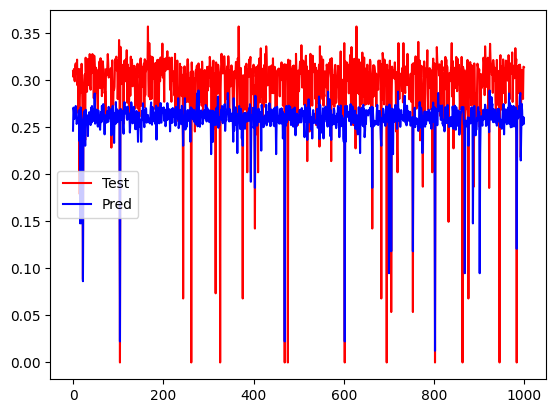

In [91]:
plot_predictions(y_test, y_pred_6)

In [92]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_6_unscaled = scaler_y.inverse_transform(y_pred_6)

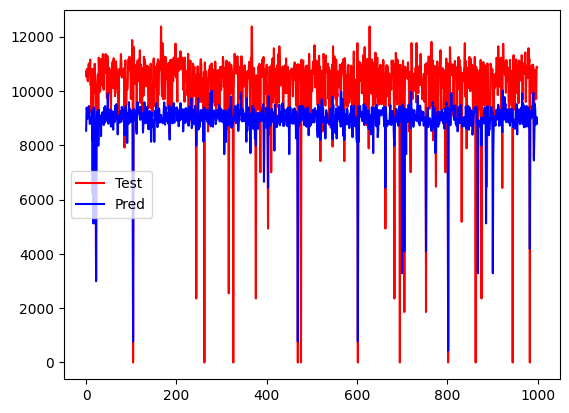

In [93]:
plot_predictions(y_test_unscaled, y_pred_6_unscaled)

### Model 7 - Changing batch size = 16

In [94]:
def init_model_7(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [95]:
model_7 = init_model_7(X_train, y_train)
model_7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [96]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=16,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [97]:
model_7, history_7 = fit_model(model_7)

Epoch 1/50
219/219 [==============================] - 11s 44ms/step - loss: 0.0396 - mae: 0.1302 - val_loss: 0.0132 - val_mae: 0.0773
Epoch 2/50
219/219 [==============================] - 9s 43ms/step - loss: 0.0137 - mae: 0.0750 - val_loss: 0.0114 - val_mae: 0.0714
Epoch 3/50
219/219 [==============================] - 9s 43ms/step - loss: 0.0118 - mae: 0.0657 - val_loss: 0.0117 - val_mae: 0.0753
Epoch 4/50
219/219 [==============================] - 9s 43ms/step - loss: 0.0110 - mae: 0.0615 - val_loss: 0.0106 - val_mae: 0.0687
Epoch 5/50
219/219 [==============================] - 9s 43ms/step - loss: 0.0108 - mae: 0.0620 - val_loss: 0.0139 - val_mae: 0.0949
Epoch 6/50
219/219 [==============================] - 10s 45ms/step - loss: 0.0108 - mae: 0.0613 - val_loss: 0.0108 - val_mae: 0.0733
Epoch 7/50
219/219 [==============================] - 10s 44ms/step - loss: 0.0113 - mae: 0.0642 - val_loss: 0.0131 - val_mae: 0.0901
Epoch 8/50
219/219 [==============================] - 10s 44ms/ste

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

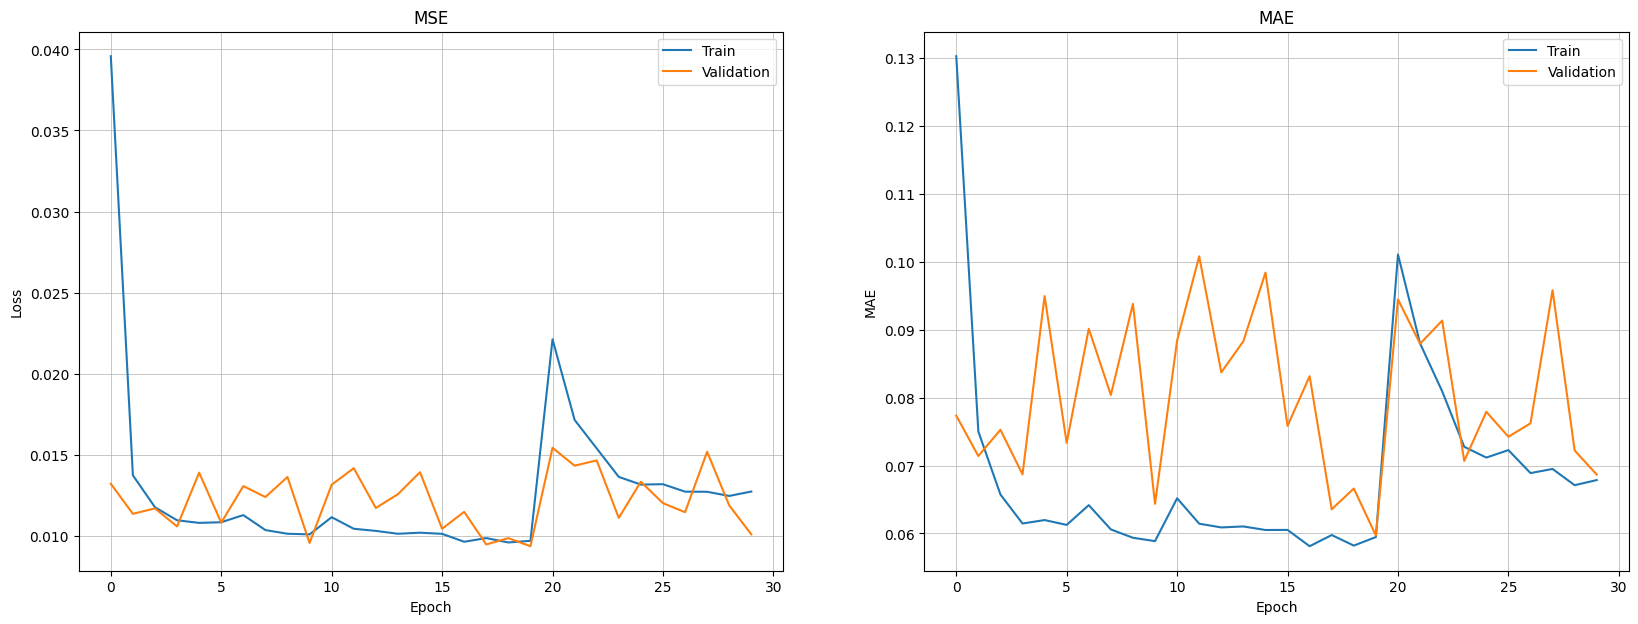

In [98]:
plot_history(history_7)

In [99]:
res7 = model_7.evaluate(X_test, y_test, verbose=0)
res7

[0.005107318516820669, 0.06457502394914627]

In [100]:
res['model_7_score'] = res7[1]

In [101]:
y_pred_7 = model_7.predict(X_test)
y_pred_7

32/32 [==============================] - 0s 8ms/step


array([[ 0.25357428],
       [ 0.2799922 ],
       [ 0.23961139],
       [ 0.23232979],
       [ 0.2289246 ],
       [ 0.240605  ],
       [ 0.24711725],
       [ 0.24538454],
       [ 0.26388967],
       [ 0.27096075],
       [ 0.23182416],
       [ 0.25941548],
       [ 0.22173597],
       [ 0.23794258],
       [ 0.211705  ],
       [ 0.22675295],
       [-0.07473692],
       [ 0.24041516],
       [ 0.23001885],
       [ 0.26303247],
       [-0.07473692],
       [ 0.22418584],
       [ 0.05478612],
       [ 0.22565097],
       [ 0.23776898],
       [ 0.22963119],
       [ 0.2686508 ],
       [ 0.17673218],
       [ 0.25432372],
       [ 0.2593703 ],
       [ 0.22643887],
       [ 0.22781254],
       [ 0.26576298],
       [ 0.18808058],
       [ 0.2265942 ],
       [ 0.22794618],
       [ 0.2355736 ],
       [ 0.24947844],
       [ 0.22958466],
       [ 0.25148195],
       [ 0.23808211],
       [ 0.2624681 ],
       [ 0.24175385],
       [ 0.24947844],
       [ 0.26884577],
       [ 0

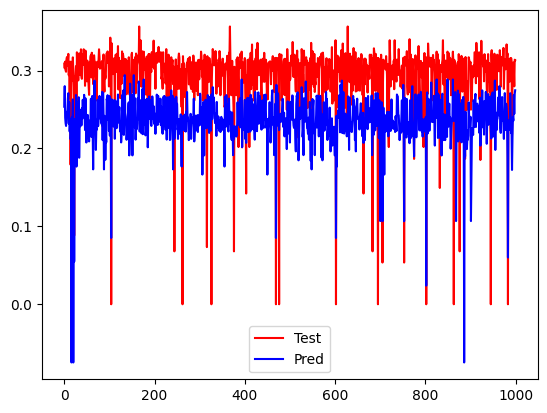

In [102]:
plot_predictions(y_test, y_pred_7)

In [103]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_7_unscaled = scaler_y.inverse_transform(y_pred_7)

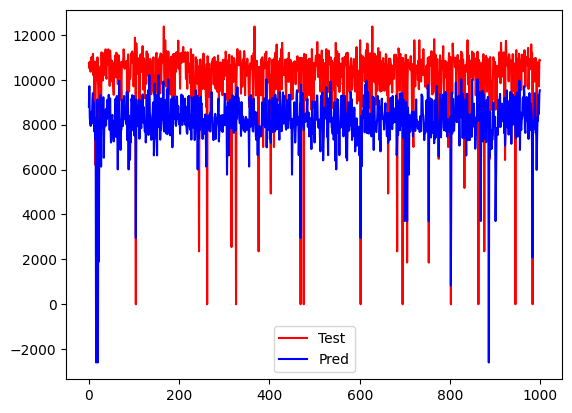

In [104]:
plot_predictions(y_test_unscaled, y_pred_7_unscaled)

### Model 8 - Changing batch size = 64

In [105]:
def init_model_8(X_train, y_train):
    
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [106]:
model_8 = init_model_8(X_train, y_train)
model_8.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [107]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=64,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [108]:
model_8, history_8 = fit_model(model_8)

Epoch 1/50
55/55 [==============================] - 4s 57ms/step - loss: 0.0884 - mae: 0.2113 - val_loss: 0.0439 - val_mae: 0.1533
Epoch 2/50
55/55 [==============================] - 3s 52ms/step - loss: 0.0399 - mae: 0.1416 - val_loss: 0.0301 - val_mae: 0.1220
Epoch 3/50
55/55 [==============================] - 3s 52ms/step - loss: 0.0266 - mae: 0.1117 - val_loss: 0.0168 - val_mae: 0.0895
Epoch 4/50
55/55 [==============================] - 3s 51ms/step - loss: 0.0175 - mae: 0.0827 - val_loss: 0.0115 - val_mae: 0.0660
Epoch 5/50
55/55 [==============================] - 3s 53ms/step - loss: 0.0138 - mae: 0.0715 - val_loss: 0.0113 - val_mae: 0.0591
Epoch 6/50
55/55 [==============================] - 3s 52ms/step - loss: 0.0124 - mae: 0.0653 - val_loss: 0.0103 - val_mae: 0.0547
Epoch 7/50
55/55 [==============================] - 3s 51ms/step - loss: 0.0128 - mae: 0.0649 - val_loss: 0.0101 - val_mae: 0.0518
Epoch 8/50
55/55 [==============================] - 3s 51ms/step - loss: 0.0117 - m

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

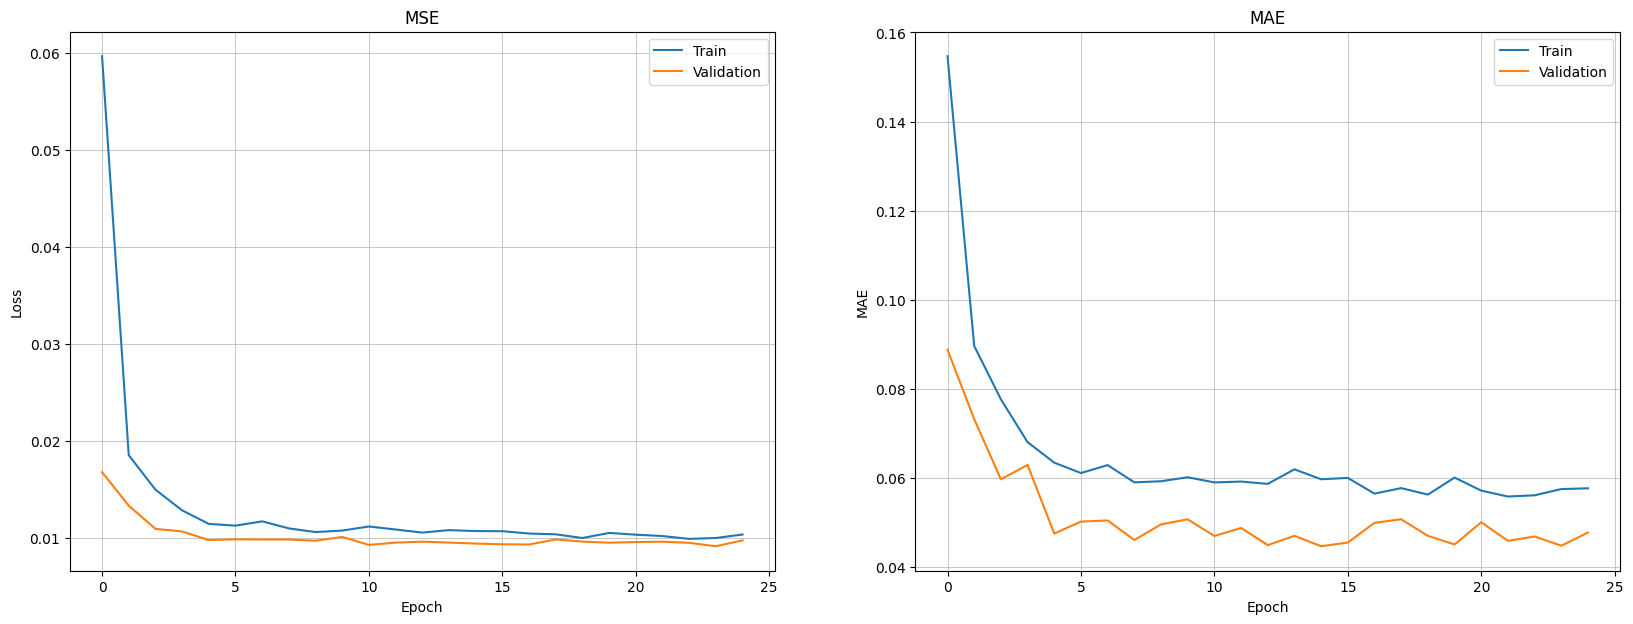

In [107]:
plot_history(history_8)

In [108]:
res8 = model_8.evaluate(X_test, y_test, verbose=0)
res8

[0.003097028937190771, 0.04783902317285538]

In [109]:
res['model_8_score'] = res8[1]

In [110]:
y_pred_8 = model_8.predict(X_test)
y_pred_8

32/32 [==============================] - 0s 8ms/step


array([[0.23559722],
       [0.27199662],
       [0.2633716 ],
       [0.2642015 ],
       [0.25951537],
       [0.26262206],
       [0.26622444],
       [0.2629703 ],
       [0.2436988 ],
       [0.241864  ],
       [0.2573661 ],
       [0.24436304],
       [0.2580365 ],
       [0.26390645],
       [0.19172022],
       [0.25999522],
       [0.12759024],
       [0.26638925],
       [0.2621807 ],
       [0.24195093],
       [0.12759024],
       [0.25653875],
       [0.09374839],
       [0.26275167],
       [0.26005074],
       [0.2620346 ],
       [0.24391353],
       [0.22673541],
       [0.2637552 ],
       [0.2428047 ],
       [0.2582776 ],
       [0.25654587],
       [0.24275932],
       [0.23338847],
       [0.25778317],
       [0.25753117],
       [0.2581895 ],
       [0.26378274],
       [0.26285094],
       [0.24272387],
       [0.26599842],
       [0.24452983],
       [0.26854455],
       [0.26378274],
       [0.24844092],
       [0.26417407],
       [0.2519672 ],
       [0.247

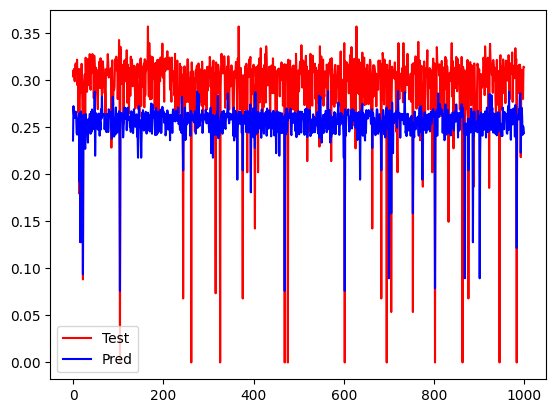

In [111]:
plot_predictions(y_test, y_pred_8)

In [112]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_8_unscaled = scaler_y.inverse_transform(y_pred_8)

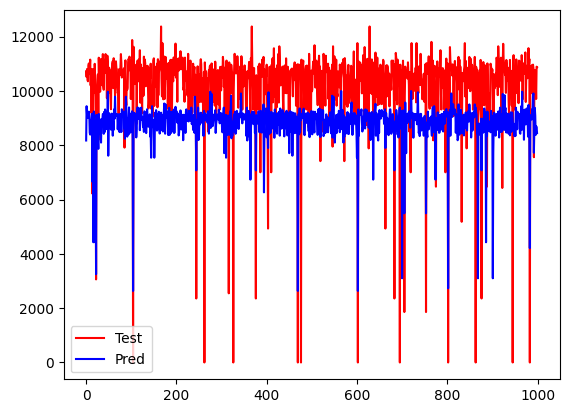

In [113]:
plot_predictions(y_test_unscaled, y_pred_8_unscaled)

### Model 9 - Using kernel regularizers

In [25]:
from tensorflow.keras import regularizers

In [26]:
def init_model_9(X_train, y_train):
    
    reg = regularizers.l1_l2(l1=0.005)
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=reg))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [27]:
model_9 = init_model_9(X_train, y_train)
model_9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [28]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=16,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [29]:
model_9, history_9 = fit_model(model_9)

Epoch 1/50


2023-03-27 23:27:49.679450: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


219/219 [==============================] - 10s 43ms/step - loss: 0.0961 - mae: 0.1415 - val_loss: 0.0525 - val_mae: 0.1119
Epoch 2/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0474 - mae: 0.1061 - val_loss: 0.0490 - val_mae: 0.0960
Epoch 3/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0431 - mae: 0.0998 - val_loss: 0.0349 - val_mae: 0.0625
Epoch 4/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0423 - mae: 0.0979 - val_loss: 0.0624 - val_mae: 0.1539
Epoch 5/50
219/219 [==============================] - 9s 42ms/step - loss: 0.0408 - mae: 0.0935 - val_loss: 0.0361 - val_mae: 0.0804
Epoch 6/50
219/219 [==============================] - 10s 43ms/step - loss: 0.0448 - mae: 0.1029 - val_loss: 0.0398 - val_mae: 0.0859
Epoch 7/50
219/219 [==============================] - 10s 45ms/step - loss: 0.0412 - mae: 0.0951 - val_loss: 0.0496 - val_mae: 0.1170
Epoch 8/50
219/219 [==============================] - 9s 42ms/step - loss: 0.

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

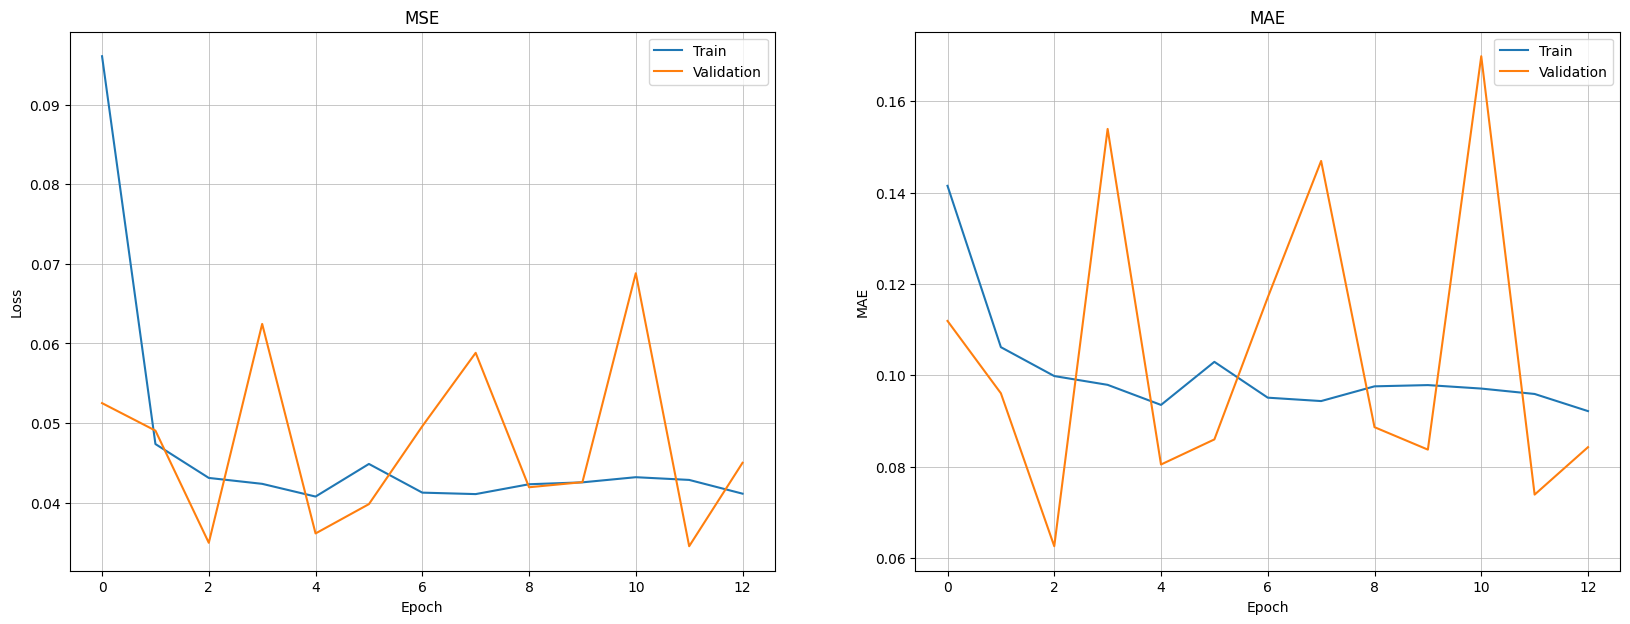

In [36]:
plot_history(history_9)

In [37]:
res9 = model_9.evaluate(X_test, y_test, verbose=0)
res9

[0.02382473461329937, 0.017595019191503525]

In [38]:
res['model_9_score'] = res9[1]

NameError: name 'res' is not defined

In [39]:
y_pred_9 = model_9.predict(X_test)
y_pred_9

32/32 [==============================] - 0s 8ms/step


array([[0.29435426],
       [0.3068607 ],
       [0.30607104],
       [0.3018437 ],
       [0.29652062],
       [0.30582452],
       [0.31066474],
       [0.2974877 ],
       [0.30447495],
       [0.30489153],
       [0.2932918 ],
       [0.3059229 ],
       [0.293754  ],
       [0.30487984],
       [0.22870186],
       [0.30296516],
       [0.30526164],
       [0.3064453 ],
       [0.29837584],
       [0.30729362],
       [0.30526164],
       [0.29352474],
       [0.29682267],
       [0.31298444],
       [0.30307752],
       [0.30193475],
       [0.30128723],
       [0.24943012],
       [0.31040633],
       [0.30454463],
       [0.29649955],
       [0.29065236],
       [0.30349934],
       [0.2568942 ],
       [0.30064398],
       [0.28978476],
       [0.30577064],
       [0.31509995],
       [0.3017087 ],
       [0.2969812 ],
       [0.30724466],
       [0.30393434],
       [0.3087895 ],
       [0.31509995],
       [0.30842897],
       [0.30761063],
       [0.29118195],
       [0.306

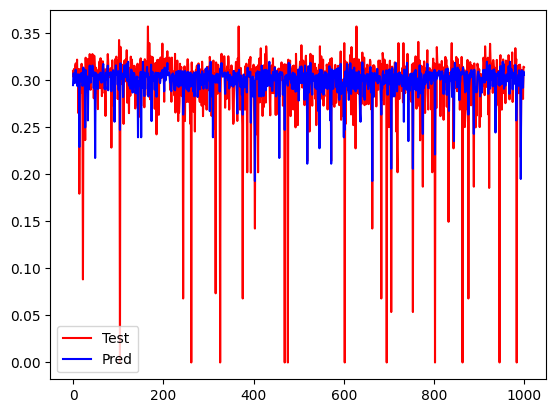

In [40]:
plot_predictions(y_test, y_pred_9)

In [41]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_9_unscaled = scaler_y.inverse_transform(y_pred_9)

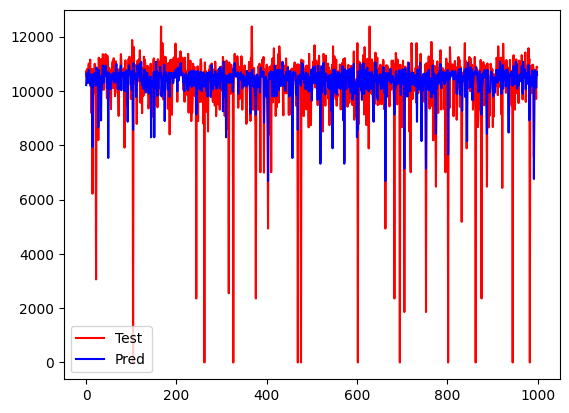

In [42]:
plot_predictions(y_test_unscaled, y_pred_9_unscaled)

In [47]:
y_test_unscaled.sum()

10201969.240063665

In [48]:
y_pred_9_unscaled.sum()

10711384.0

## Choosing the best model

In [123]:
baseline_score[1]

0.03702442720532417

In [124]:
res

{'baseline_score': 0.03702442720532417,
 'model_1_score': 0.021047960966825485,
 'model_2_score': 0.025921424850821495,
 'model_3_score': 0.03747788816690445,
 'model_4_score': 0.031945157796144485,
 'model_5_score': 0.029720492660999298,
 'model_6_score': 0.04398607090115547,
 'model_7_score': 0.06457502394914627,
 'model_9_score': 0.02033139392733574}

In [125]:
for key, value in res.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")

🏋🏽‍♂️ baseline_score improvement over baseline: 0.0 % 

🏋🏽‍♂️ model_1_score improvement over baseline: 43.15 % 

🏋🏽‍♂️ model_2_score improvement over baseline: 29.99 % 

🏋🏽‍♂️ model_3_score improvement over baseline: -1.22 % 

🏋🏽‍♂️ model_4_score improvement over baseline: 13.72 % 

🏋🏽‍♂️ model_5_score improvement over baseline: 19.73 % 

🏋🏽‍♂️ model_6_score improvement over baseline: -18.8 % 

🏋🏽‍♂️ model_7_score improvement over baseline: -74.41 % 

🏋🏽‍♂️ model_9_score improvement over baseline: 45.09 % 



In [126]:
def find_min_model_score(dic):
    min_score = min(dic.values())
    min_model = [k for k in dic if dic[k] == min_score]
    return min_model, min_score

In [127]:
min_model, min_score = find_min_model_score(res)
print(f"The model with the lowest score {min_score} is {min_model}")

The model with the lowest score 0.02033139392733574 is ['model_9_score']


###### Save the results for each run

No kernel restart

In [128]:
best_models_run_1 = {'baseline_score': 0.03702442720532417,
 'model_1_score': 0.04049758240580559,
 'model_2_score': 0.02823290042579174,
 'model_3_score': 0.030733002349734306,
 'model_4_score': 0.03173057734966278,
 'model_5_score': 0.025329547002911568,
 'model_6_score': 0.03669685497879982,
 'model_7_score': 0.02507651597261429,
 'model_8_score': 0.022292515262961388,
 'model_9_score': 0.019101908430457115}

In [129]:
for key, value in best_models_run_1.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")
    
min_model, min_score = find_min_model_score(best_models_run_1)
print(f"The model with the best score {round(min_score,4)} is {min_model}")

🏋🏽‍♂️ baseline_score improvement over baseline: 0.0 % 

🏋🏽‍♂️ model_1_score improvement over baseline: -9.38 % 

🏋🏽‍♂️ model_2_score improvement over baseline: 23.75 % 

🏋🏽‍♂️ model_3_score improvement over baseline: 16.99 % 

🏋🏽‍♂️ model_4_score improvement over baseline: 14.3 % 

🏋🏽‍♂️ model_5_score improvement over baseline: 31.59 % 

🏋🏽‍♂️ model_6_score improvement over baseline: 0.88 % 

🏋🏽‍♂️ model_7_score improvement over baseline: 32.27 % 

🏋🏽‍♂️ model_8_score improvement over baseline: 39.79 % 

🏋🏽‍♂️ model_9_score improvement over baseline: 48.41 % 

The model with the best score 0.0191 is ['model_9_score']


----------------------

Kernel restart

In [130]:
best_models_run_2 = {'baseline_score': 0.03702442720532417,
 'model_1_score': 0.05282909795641899,
 'model_2_score': 0.031305912882089615,
 'model_3_score': 0.020754190161824226,
 'model_4_score': 0.050198450684547424,
 'model_5_score': 0.020747225731611252,
 'model_6_score': 0.02194497361779213,
 'model_7_score': 0.04238642752170563,
 'model_8_score': 0.02303718961775303,
 'model_9_score': 0.024834586307406425}

In [131]:
for key, value in best_models_run_2.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")
    
min_model, min_score = find_min_model_score(best_models_run_2)
print(f"The model with the best score {round(min_score,2)} is {min_model}")

🏋🏽‍♂️ baseline_score improvement over baseline: 0.0 % 

🏋🏽‍♂️ model_1_score improvement over baseline: -42.69 % 

🏋🏽‍♂️ model_2_score improvement over baseline: 15.45 % 

🏋🏽‍♂️ model_3_score improvement over baseline: 43.94 % 

🏋🏽‍♂️ model_4_score improvement over baseline: -35.58 % 

🏋🏽‍♂️ model_5_score improvement over baseline: 43.96 % 

🏋🏽‍♂️ model_6_score improvement over baseline: 40.73 % 

🏋🏽‍♂️ model_7_score improvement over baseline: -14.48 % 

🏋🏽‍♂️ model_8_score improvement over baseline: 37.78 % 

🏋🏽‍♂️ model_9_score improvement over baseline: 32.92 % 

The model with the best score 0.02 is ['model_5_score']


In [132]:
best_models_run_3 = {'baseline_score': 0.0357062891125679,
 'model_1_score': 0.025948183611035347,
 'model_2_score': 0.02978791482746601,
 'model_3_score': 0.03173263370990753,
 'model_4_score': 0.030164388939738274,
 'model_5_score': 0.046731818467378616,
 'model_6_score': 0.045156411826610565,
 'model_7_score': 0.023993121460080147,
 'model_8_score': 0.0310027077794075,
 'model_9_score': 0.09930799901485443}

In [133]:
for key, value in best_models_run_3.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")

min_model, min_score = find_min_model_score(best_models_run_3)
print(f"The model with the best score {round(min_score,4)} is {min_model}")

🏋🏽‍♂️ baseline_score improvement over baseline: 3.56 % 

🏋🏽‍♂️ model_1_score improvement over baseline: 29.92 % 

🏋🏽‍♂️ model_2_score improvement over baseline: 19.55 % 

🏋🏽‍♂️ model_3_score improvement over baseline: 14.29 % 

🏋🏽‍♂️ model_4_score improvement over baseline: 18.53 % 

🏋🏽‍♂️ model_5_score improvement over baseline: -26.22 % 

🏋🏽‍♂️ model_6_score improvement over baseline: -21.96 % 

🏋🏽‍♂️ model_7_score improvement over baseline: 35.2 % 

🏋🏽‍♂️ model_8_score improvement over baseline: 16.26 % 

🏋🏽‍♂️ model_9_score improvement over baseline: -168.22 % 

The model with the best score 0.024 is ['model_7_score']


Restart kernel

In [134]:
best_models_run_4 = {'baseline_score': 0.03702442720532417,
 'model_1_score': 0.04644494131207466,
 'model_2_score': 0.02422655001282692,
 'model_3_score': 0.04077880084514618,
 'model_4_score': 0.0313691645860672,
 'model_5_score': 0.028408152982592583,
 'model_6_score': 0.0483388714492321,
 'model_7_score': 0.05146443471312523,
 'model_8_score': 0.03711487352848053,
 'model_9_score': 0.01772143505513668}

In [135]:
for key, value in best_models_run_4.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")

min_model, min_score = find_min_model_score(best_models_run_4)
print(f"The model with the best score {round(min_score,4)} is {min_model}")

🏋🏽‍♂️ baseline_score improvement over baseline: 0.0 % 

🏋🏽‍♂️ model_1_score improvement over baseline: -25.44 % 

🏋🏽‍♂️ model_2_score improvement over baseline: 34.57 % 

🏋🏽‍♂️ model_3_score improvement over baseline: -10.14 % 

🏋🏽‍♂️ model_4_score improvement over baseline: 15.27 % 

🏋🏽‍♂️ model_5_score improvement over baseline: 23.27 % 

🏋🏽‍♂️ model_6_score improvement over baseline: -30.56 % 

🏋🏽‍♂️ model_7_score improvement over baseline: -39.0 % 

🏋🏽‍♂️ model_8_score improvement over baseline: -0.24 % 

🏋🏽‍♂️ model_9_score improvement over baseline: 52.14 % 

The model with the best score 0.0177 is ['model_9_score']


Restart kernel

In [136]:
best_models_run_5 = {'baseline_score': 0.03702442720532417,
 'model_1_score': 0.04316176101565361,
 'model_2_score': 0.028216861188411713,
 'model_3_score': 0.02285226434469223,
 'model_4_score': 0.03192143142223358,
 'model_5_score': 0.027002785354852676,
 'model_6_score': 0.02485913410782814,
 'model_7_score': 0.029108060523867607,
 'model_8_score': 0.04784145951271057,
 'model_9_score': 0.018474649637937546}

In [137]:
for key, value in best_models_run_5.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")

min_model, min_score = find_min_model_score(best_models_run_5)
print(f"The model with the best score {round(min_score,4)} is {min_model}")

🏋🏽‍♂️ baseline_score improvement over baseline: 0.0 % 

🏋🏽‍♂️ model_1_score improvement over baseline: -16.58 % 

🏋🏽‍♂️ model_2_score improvement over baseline: 23.79 % 

🏋🏽‍♂️ model_3_score improvement over baseline: 38.28 % 

🏋🏽‍♂️ model_4_score improvement over baseline: 13.78 % 

🏋🏽‍♂️ model_5_score improvement over baseline: 27.07 % 

🏋🏽‍♂️ model_6_score improvement over baseline: 32.86 % 

🏋🏽‍♂️ model_7_score improvement over baseline: 21.38 % 

🏋🏽‍♂️ model_8_score improvement over baseline: -29.22 % 

🏋🏽‍♂️ model_9_score improvement over baseline: 50.1 % 

The model with the best score 0.0185 is ['model_9_score']


Restart Kernel

In [138]:
best_models_run_6 = {'baseline_score': 0.03702442720532417,
 'model_1_score': 0.03413788974285126,
 'model_2_score': 0.03728388622403145,
 'model_3_score': 0.028809405863285065,
 'model_4_score': 0.05029528960585594,
 'model_5_score': 0.026066768914461136,
 'model_6_score': 0.02701212652027607,
 'model_7_score': 0.0549078993499279,
 'model_8_score': 0.02208194136619568,
 'model_9_score': 0.017235204577445984}

In [139]:
for key, value in best_models_run_6.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")

min_model, min_score = find_min_model_score(best_models_run_6)
print(f"The model with the best score {round(min_score,4)} is {min_model}")

🏋🏽‍♂️ baseline_score improvement over baseline: 0.0 % 

🏋🏽‍♂️ model_1_score improvement over baseline: 7.8 % 

🏋🏽‍♂️ model_2_score improvement over baseline: -0.7 % 

🏋🏽‍♂️ model_3_score improvement over baseline: 22.19 % 

🏋🏽‍♂️ model_4_score improvement over baseline: -35.84 % 

🏋🏽‍♂️ model_5_score improvement over baseline: 29.6 % 

🏋🏽‍♂️ model_6_score improvement over baseline: 27.04 % 

🏋🏽‍♂️ model_7_score improvement over baseline: -48.3 % 

🏋🏽‍♂️ model_8_score improvement over baseline: 40.36 % 

🏋🏽‍♂️ model_9_score improvement over baseline: 53.45 % 

The model with the best score 0.0172 is ['model_9_score']


In [140]:
best_models_run_7 = {'baseline_score': 0.03702442720532417,
 'model_1_score': 0.030128419399261475,
 'model_2_score': 0.0651567205786705,
 'model_3_score': 0.03367955610156059,
 'model_4_score': 0.032095156610012054,
 'model_5_score': 0.019123604521155357,
 'model_6_score': 0.016778510063886642,
 'model_7_score': 0.06496649235486984,
 'model_8_score': 0.021903252229094505,
 'model_9_score': 0.023749228566884995}

In [141]:
for key, value in best_models_run_7.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")

min_model, min_score = find_min_model_score(best_models_run_7)
print(f"The model with the best score {round(min_score,4)} is {min_model}")

🏋🏽‍♂️ baseline_score improvement over baseline: 0.0 % 

🏋🏽‍♂️ model_1_score improvement over baseline: 18.63 % 

🏋🏽‍♂️ model_2_score improvement over baseline: -75.98 % 

🏋🏽‍♂️ model_3_score improvement over baseline: 9.03 % 

🏋🏽‍♂️ model_4_score improvement over baseline: 13.31 % 

🏋🏽‍♂️ model_5_score improvement over baseline: 48.35 % 

🏋🏽‍♂️ model_6_score improvement over baseline: 54.68 % 

🏋🏽‍♂️ model_7_score improvement over baseline: -75.47 % 

🏋🏽‍♂️ model_8_score improvement over baseline: 40.84 % 

🏋🏽‍♂️ model_9_score improvement over baseline: 35.86 % 

The model with the best score 0.0168 is ['model_6_score']


In [142]:
best_models_run_8 = {'baseline_score': 0.03702442720532417,
 'model_1_score': 0.021047960966825485,
 'model_2_score': 0.025921424850821495,
 'model_3_score': 0.03747788816690445,
 'model_4_score': 0.031945157796144485,
 'model_5_score': 0.029720492660999298,
 'model_6_score': 0.04398607090115547,
 'model_7_score': 0.06457502394914627,
 'model_9_score': 0.02033139392733574}

In [143]:
for key, value in best_models_run_7.items():
    print(f"🏋🏽‍♂️ {key} improvement over baseline: {round((1 - (value/baseline_score[1]))*100,2)} % \n")

min_model, min_score = find_min_model_score(best_models_run_7)
print(f"The model with the best score {round(min_score,4)} is {min_model}")

🏋🏽‍♂️ baseline_score improvement over baseline: 0.0 % 

🏋🏽‍♂️ model_1_score improvement over baseline: 18.63 % 

🏋🏽‍♂️ model_2_score improvement over baseline: -75.98 % 

🏋🏽‍♂️ model_3_score improvement over baseline: 9.03 % 

🏋🏽‍♂️ model_4_score improvement over baseline: 13.31 % 

🏋🏽‍♂️ model_5_score improvement over baseline: 48.35 % 

🏋🏽‍♂️ model_6_score improvement over baseline: 54.68 % 

🏋🏽‍♂️ model_7_score improvement over baseline: -75.47 % 

🏋🏽‍♂️ model_8_score improvement over baseline: 40.84 % 

🏋🏽‍♂️ model_9_score improvement over baseline: 35.86 % 

The model with the best score 0.0168 is ['model_6_score']


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (9,).

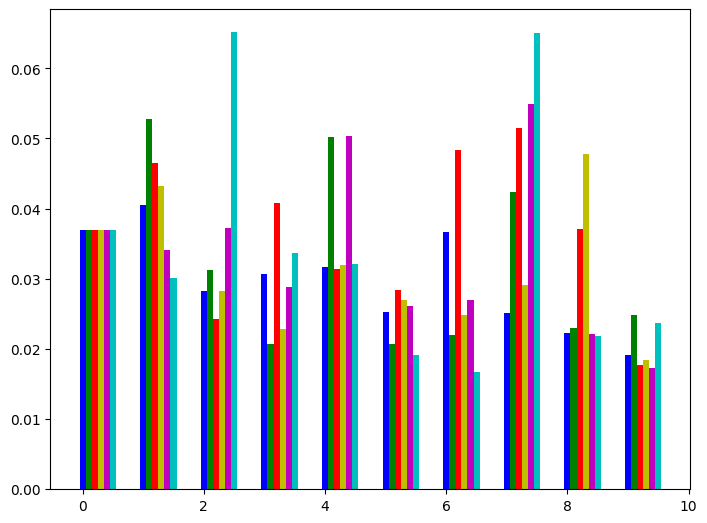

In [148]:
keys = best_models_run_1.keys()
values1 = best_models_run_1.values()
values2 = best_models_run_2.values()
#values3 = best_models_run_3.values()
values4 = best_models_run_4.values()
values5 = best_models_run_5.values()
values6 = best_models_run_6.values()
values7 = best_models_run_7.values()
values8 = best_models_run_8.values()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(len(keys))
ax.bar(X + 0.00, values1, color = 'b', width = 0.10)
ax.bar(X + 0.10, values2, color = 'g', width = 0.10)
ax.bar(X + 0.20, values4, color = 'r', width = 0.10)
ax.bar(X + 0.30, values5, color = 'y', width = 0.10)
ax.bar(X + 0.40, values6, color = 'm', width = 0.10)
ax.bar(X + 0.50, values7, color = 'c', width = 0.10)
ax.bar(X + 0.60, values8, color = 'k', width = 0.10)




plt.show()

plt.show()

## Train on real data with model 9

In [ ]:
def subsample_sequence(sequence, length, horizon):

    # Bounds of sampling
    last_possible = len(sequence) - length - horizon
    random_start = np.random.randint(0, last_possible)

    # Sample
    X = sequence.iloc[random_start:random_start + length, :].drop(columns=['Date'])
    #iloc[random_start:random_start + length, :] 
    #[random_start:random_start +length].drop(columns=['Date','Qoil MPFM']) 
    y = sequence.iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #iloc[random_start + length:random_start + length + horizon, :]['Qoil MPFM']
    #loc[random_start+length+horizon-1]['Qoil MPFM']

    return X, y


subsample_sequence(df_train, 3, 1)

In [33]:
def get_real_X_y(sequence, length, horizon):
    
    X, y = [], []
    
    # Do as many samples as specified
    for i in range(1,len(sequence)-length):
    
        # Record sample X & y
        xi = sequence.iloc[i:i + length, :].drop(columns=['Date'])
        yi = sequence.iloc[i + length:i + length + horizon, :]['Qoil MPFM']
        X.append(np.array(xi.values.T.tolist()).T) # Getting the right shape (sequences, observations,features)
        y.append(yi)

    return np.array(X), np.array(y)

In [34]:
X_test_real, y_test_real = get_real_X_y(df_test, 500, 1)

In [35]:
X_test_real.shape

(595, 500, 16)

In [43]:
X_test_real = scaler_X.transform(X_test_real.reshape(-1,X_test_real.shape[-1])).reshape(X_test_real.shape)

In [45]:
y_pred_real = model_9.predict(X_test_real)

19/19 [==============================] - 0s 8ms/step


In [47]:
y_pred_real_unscaled = scaler_y.inverse_transform(y_pred_real)

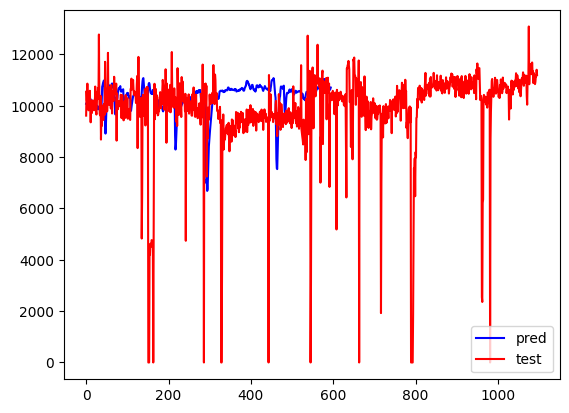

In [51]:
plt.plot(y_pred_real_unscaled, c='b', label='pred')
plt.plot(df_test['Qoil MPFM'].values, c='r', label='test')
plt.legend()
plt.show()

In [176]:
def init_model_10(X_train, y_train):
    
    reg = regularizers.l1_l2(l1=0.005)
    
    #arquitecture
    model = models.Sequential()
    model.add(layers.LSTM(8, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=reg))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [177]:
model_10 = init_model_10(X_train_all_3d, y_train_all_3d)
model_10.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 8)                 800       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [178]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train_all_3d, y_train_all_3d,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=16,
                        epochs=50,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [179]:
model_10, history_10 = fit_model(model_10)

Epoch 1/50
207/207 [==============================] - 1s 2ms/step - loss: 0.0639 - mae: 0.0775 - val_loss: 0.0268 - val_mae: 0.0932
Epoch 2/50
207/207 [==============================] - 0s 748us/step - loss: 0.0438 - mae: 0.0803 - val_loss: 0.0278 - val_mae: 0.0973
Epoch 3/50
207/207 [==============================] - 0s 738us/step - loss: 0.0426 - mae: 0.0868 - val_loss: 0.0282 - val_mae: 0.0991
Epoch 4/50
207/207 [==============================] - 0s 744us/step - loss: 0.0420 - mae: 0.0906 - val_loss: 0.0300 - val_mae: 0.1001
Epoch 5/50
207/207 [==============================] - 0s 746us/step - loss: 0.0420 - mae: 0.0900 - val_loss: 0.0293 - val_mae: 0.0998
Epoch 6/50
207/207 [==============================] - 0s 742us/step - loss: 0.0414 - mae: 0.0925 - val_loss: 0.0300 - val_mae: 0.1008
Epoch 7/50
207/207 [==============================] - 0s 744us/step - loss: 0.0415 - mae: 0.0930 - val_loss: 0.0288 - val_mae: 0.1011
Epoch 8/50
207/207 [==============================] - 0s 745us/s

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

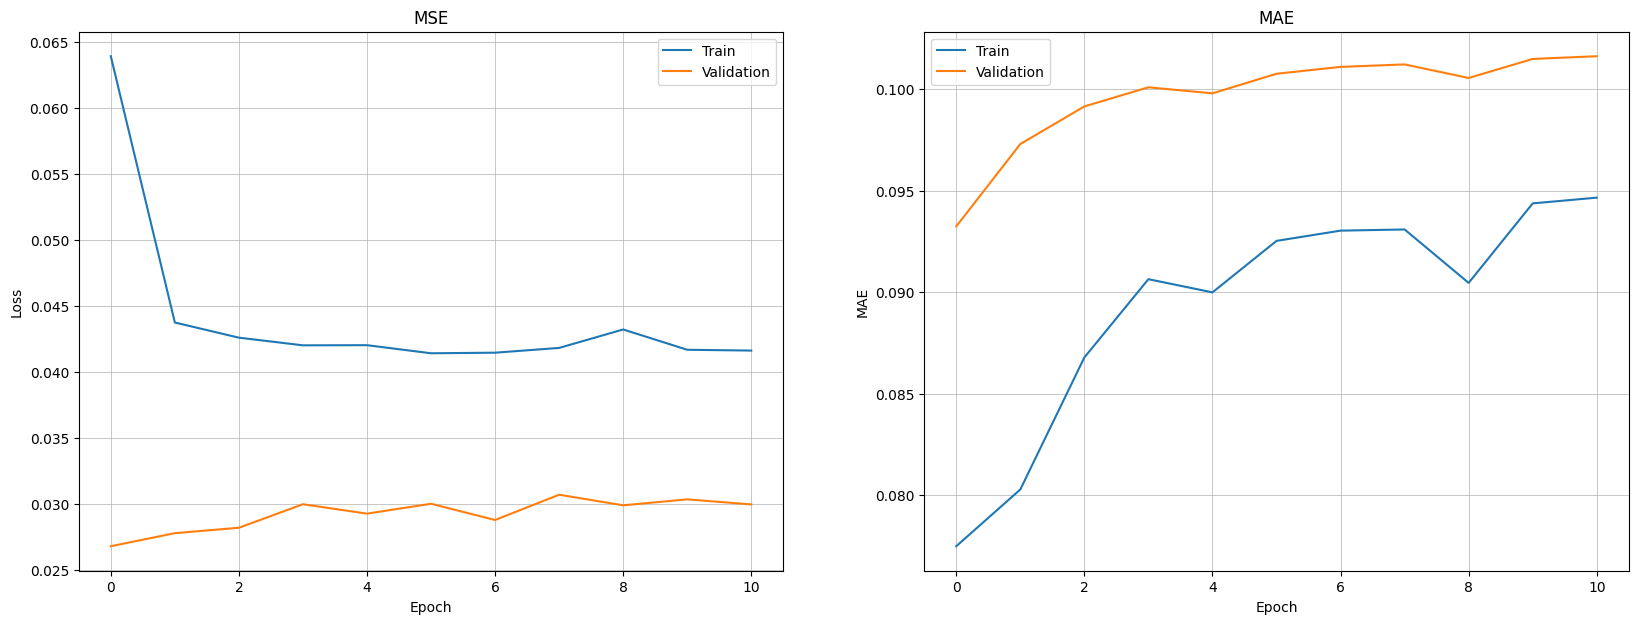

In [180]:
plot_history(history_10)

In [182]:
res10 = model_10.evaluate(X_test_all_3d, y_test_all_3d, verbose=0)
res10

[0.021688111126422882, 0.07706861197948456]

In [ ]:
res['model_10_score'] = res10[1]

In [184]:
y_pred_10 = model_10.predict(X_test_all_3d)
y_pred_10

35/35 [==============================] - 0s 426us/step


array([[0.27814642],
       [0.27817485],
       [0.27817   ],
       ...,
       [0.2778623 ],
       [0.2778716 ],
       [0.2778661 ]], dtype=float32)

In [186]:
y_test_all_unscaled = scaler_all_y.inverse_transform(y_test_all)
y_pred_10_unscaled = scaler_all_y.inverse_transform(y_pred_10)

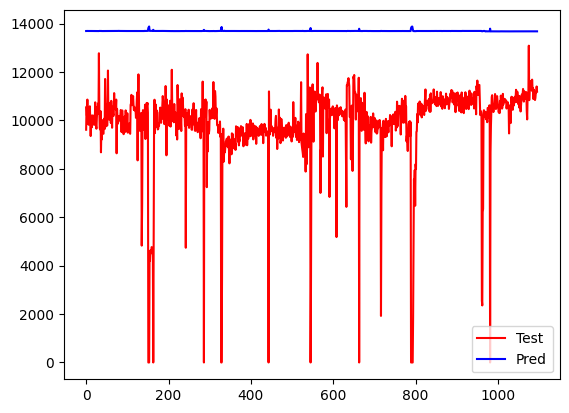

In [187]:
plot_predictions(y_test_all_unscaled, y_pred_10_unscaled)